# pRT 2

In [13]:
import pymultinest
import petitRADTRANS

In [14]:
from petitRADTRANS.radtrans import Radtrans
radtrans = Radtrans(line_species=['CH4'])

/Users/salirafi/.pyenv/versions/3.10.14/envs/for_pRT_31014/lib/python3.10/site-packages/petitRADTRANS/radtrans.py:118: UserWarning: pressure was not set, initializing one layer at 1 bar
  warnings.warn("pressure was not set, initializing one layer at 1 bar")


Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/Users/salirafi/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
Successfully loaded all opacities


In [15]:
import numpy as np
import pyfastchem
import matplotlib.pyplot as plt
import astropy.constants as const
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import os
os.environ['pRT_input_data_path'] = '/Users/salirafi/input_data' # path to the opacity folder
import pickle

from petitRADTRANS import Radtrans
from petitRADTRANS.physics import guillot_global
import petitRADTRANS.nat_cst as nc

from function import inst_gaussian
from function import rotation_flux
from function import high_pass_filter

ImportError: cannot import name 'Radtrans' from 'petitRADTRANS' (/Users/salirafi/.pyenv/versions/3.10.14/envs/for_pRT_31014/lib/python3.10/site-packages/petitRADTRANS/__init__.py)

In [ ]:
class Generate_Model():

    def __init__(self,pressure,temperature,P0,cloud,
                 mol,absorbent_fastchem,absorbent_radtrans):

        """
        pressure    : pressure (bar)
        temperature : temperature (K)
        """

        self.pressure = pressure
        self.temperature = temperature
        self.P0 = P0
        self.cloud = cloud
        self.mol = mol
        self.absorbent_fastchem = absorbent_fastchem
        self.absorbent_radtrans = absorbent_radtrans

    # function for model generation (using petitRADTRANS) assuming chemical equilibrium abundances
    def modeling(self, fastchem, output_data, **kwargs):

        """
        If a constant VMR is assumed, then the species of interest will be the only species with a constant VMR. The rest assumes chemical equilibrium.
        It is important to note that this does not represent any real physical condition.
        """

        # common input for all molecules

        # define reference radius and gravity at arbitrary pressure (which is assumed at the planetary surface with a pressure of P0)
        R_pl = self.Rp * nc.r_jup_mean                      # meter
        gravity = nc.G * self.Mp * nc.m_jup / R_pl ** 2     # meter per second squared

        ######################### Calculating VMR, mass fractions, and MMW from fastChem output #########################

        # getting the number densities (in molecules cm^-3)
        number_densities = np.array(output_data.number_densities)

        # total gas particle number density (molecules cm^-3) from ideal gas law, used later to convert the number densities to mixing ratios
        gas_number_density = self.pressure * 1e6 / (const.k_B.cgs * self.temperature)

        # if the species of interest is assumed with constant VMR
        if kwargs['homogeneous']:
            for idx,const_spec in enumerate(kwargs['constant_species']):
                number_densities[:, fastchem.getGasSpeciesIndex(const_spec)] = kwargs['constant_mixing_ratio'][idx] * gas_number_density

        # calculate mixing ratios
        mixing_ratios = number_densities / gas_number_density[:,np.newaxis]

        # getting the molecular weight
        molec_weight = np.zeros((fastchem.getGasSpeciesNumber()))
        for species_idx in range(fastchem.getGasSpeciesNumber()):
            molec_weight[species_idx] = fastchem.getGasSpeciesWeight(species_idx)

        # calculate mass fractions
        mass_densities = number_densities * molec_weight[np.newaxis, :]
        mass_fractions = mass_densities / np.sum(mass_densities, axis=1)[:, np.newaxis]

        # calculate the mean molecular weight
        mmw = np.sum(mixing_ratios*molec_weight[np.newaxis,:],axis=1)
        # mmw_fastchem = np.array(output_data.mean_molecular_weight)

        # defining mass fractions dictionary for petitRADTANS
        mass_frac = {}
        for idx,abso in enumerate(self.absorbent_fastchem):
            mass_frac[self.absorbent_radtrans[idx]] = mass_fractions[:, fastchem.getGasSpeciesIndex(abso)]

        # calculate the transmission spectrum
        if self.cloud == False:
            self.mol.calc_transm(self.temperature, mass_frac, gravity, np.asarray(mmw), 
                                 R_pl = R_pl, P0_bar = self.P0)
        else:
            self.mol.calc_transm(self.temperature, mass_frac, gravity, np.asarray(mmw), 
                                 R_pl = R_pl, P0_bar = self.P0, Pcloud = self.cloud)

        return nc.c / self.mol.freq, 1 - np.square(self.mol.transm_rad / (self.Rs * nc.r_sun))  # wavelength in cm, flux in 1-(Rp/Rs)^2
    
    # function for convolving model with instrument resolution and rotational broadening
    def model_prepare(self, metallicity, CO_rat, R_data, vsini, limb_coeff, binmedfil, bingauss, R_model=1e6, plot=True, homo=False, vmr_constant=False, normalize=False, divide_normalization=False):

        # calculate instrumental FWHM
        c = const.c.value / 1000. # km/s
        FWHM = c / R_data

        # convolving model with Gaussian kernel (function needs x-axis to be evenly sampled in velocity or log-wavenumber; Kawahara+ 2022)
        max_wavenum,min_wavenum = 1/self.wave_model[0], 1/self.wave_model[-1] # cm^-1
        N_wvbin = int(R_model * np.log(max_wavenum/(min_wavenum-5)) + 1.) # from Kawahara+ (2022)
        wavenum = np.logspace(np.log10(min_wavenum), np.log10(max_wavenum), N_wvbin, dtype=np.float64) # define the wavenumber in linear logarithm space since we want to define the kernel in velocity space
        flux_transm_wvnum = interp1d(1/self.wave_model,self.flux_model,kind='cubic',fill_value='extrapolate')(wavenum)
        flux_mod_planet = inst_gaussian(wavenum,flux_transm_wvnum,FWHM) # as a function of wavenumber

        # rotationally broadened model (function needs x-axis to be evenly spaced)
        wave_even = np.arange((1/wavenum*1e+8)[-1],(1/wavenum*1e+8)[0],0.01) # convert cm to angstrom
        flux_broad = interp1d(1/wavenum*1e+8,flux_mod_planet,kind='cubic',fill_value='extrapolate')(wave_even)
        # flux_broad = rotation_flux(wave_even,flux_mod_planet_even,vsini,limb_coeff[0],limb_coeff[1])

        # normalizing model by division to preserve the line shape and contrast (line depth relative to continuum) or subtract it since we want the model to have 0 continuum
        if normalize:
            # applying high-pass filter to fit pseudo-continuum
            med_fil = high_pass_filter(flux_broad[50:-50],binmedfil,maxval=True) # use the maximum value
            gauss_fil = gaussian_filter1d(med_fil,bingauss)
            flux_modelmol = flux_broad[50:-50] / gauss_fil if divide_normalization else flux_broad[50:-50] - gauss_fil
        else:
            flux_modelmol = flux_broad[50:-50]

        wave_modelmol = wave_even[50:-50]

        if plot:
            plt.figure(figsize=(20,10))
            plt.subplot(211)
            plt.plot(self.wave_model[50:-50]*1e+8,self.flux_model[50:-50],label='Initial')
            plt.plot(1/wavenum[50:-50]*1e+8,flux_mod_planet[50:-50],label='Gaussian-convolved')
            plt.plot(wave_even[50:-50],flux_broad[50:-50],label='Rotationally-broadened')
            plt.plot(wave_even[50:-50],gauss_fil,label='High-pass filter')
            # # plt.plot(wave_even[50:-50],fit_continuum,label='High-pass filter')
            plt.ylabel(r'$1-\rm (R_p/R_s)^2$')
            plt.xlabel(r'Wavelength ($\AA$)')
            if homo:
                plt.title('HD 149026 b ' + str(self.absorbent_radtrans)+' spectrum (C/O = '+str(CO_rat)+', Fe/H = '+str(metallicity)+r', $T_{eff}$ = '\
                    +str(int(np.mean(self.temperature)))+' K, cloud = '+str(self.cloud)+', Vsin(i) = '+str(round(vsini,2))+', VMR = '+str(vmr_constant)+')')
            else:
                plt.title('HD 149026 b ' + str(self.absorbent_radtrans) + ' spectrum (C/O = ' + str(CO_rat) + ', Fe/H = ' + str(metallicity) + r', $T_{eff}$ = '\
                        + str(int(np.mean(self.temperature))) + ' K, cloud = ' + str(self.cloud) +', Vsin(i) = ' +str(round(vsini,2))+ ')')
            plt.legend()
            
            plt.subplot(212)
            plt.plot(wave_modelmol,flux_modelmol)
            plt.show(block=False)

            plt.show()
            plt.clf()

        return wave_modelmol,flux_modelmol

In [ ]:
line_list = ['H2O_POKAZATEL_cust']                        # opacity folder name in 'pRT_input_data_path'
# line_list = ['H2O_HITEMP2010_cust']
fastchem_species_symbol = ['H2O1']                        # species name in fastchem format
# line_list = ['HCN_main_iso']
# fastchem_species_symbol = ['C1H1N1_1']

################################# Defining Radtrans object #####################################

mol = Radtrans(line_species = line_list,
              rayleigh_species = ['H2', 'He'],
              continuum_opacities = ['H-','H2-He' ,'H2-H2'],
              mode = 'lbl',
              wlen_bords_micron = [0.95, 1.8])

/Users/salirafi/Documents/master-project/py3918env/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_POKAZATEL_cust...

  Read CIA opacities for H2-He...
  Read CIA opacities for H2-H2...
Done.



In [ ]:
# for isothermal TP-profile and non-homogenous atmosphere or VMR constant for only one species of interest

Rs = 1.41         # Sun radii, from Stassun+ 2017
ap = 0.04364      # AU, from Bonomo+ 2017
Ts = 6179         # K, from Stassun+ 2017
Mp = 0.322        # Jupiter mass, from Bonomo+ 2017
Rp = 0.811        # Jupiter radii, from Bonomo+ 2017

pressure = np.logspace(-8,2,100)                            # bar
t_eq = 1700                                                 # Kelvin (assuming eq. temperature)
temperature = t_eq * np.ones_like(pressure)                 # isothermal profile
P0 = 10                                                     # bar
CO_rat = 'solar'
cloud = False                                             # cloud deck pressure in log10 bar; since we set the surface at P0, then P0 cloud is basically cloud-free

P = 2.8758916                                                       # days, from Bonomo+ 2017                                      
vsini = 1e-10 # 2 * np.pi * model.Rp * nc.r_jup_mean/100000 / (P*86400)     # in km/s --> 2*pi*R/P (assuming circular orbit)
limb_coeff = [0.075, 0.372]                                         # quadratic limb darkening (calculated from https://exoctk.stsci.edu/limb_darkening)
R_data = 80400
binmedfil,bingauss = 2000,1500

######################### Guillot profile #########################

# # below if Guillot (2010) profile is desired

# R_pl = Rp * nc.r_jup_mean
# gravity = nc.G * Mp * nc.m_jup / R_pl ** 2

# t_eq = t_eq # float(input('t_eq: '))
# kappa_IR = 0.01  # float(input('kappa_IR: '))
# gamma = 0.5  # float(input('gamma: ')) #0.5
# T_int = 0.39 * t_eq * np.exp(-np.square(np.log10(4 * nc.sigma * t_eq ** 4 / 1e+9) - 0.14) / 1.095)  # flux in Gerg s^-1 cm^-2 (Thorngren+ 2019)
# T_equ = Ts * np.sqrt(Rs * nc.r_sun / 2 / ap / nc.AU)                                                # follwing Guillot+ (2010)
# temperature = guillot_global(pressure, kappa_IR, gamma, gravity, T_int, T_equ)

###########################################################################

# includes H- opacity
absorbent_fastchem = ['e-','H','H2','He','H1-'] + fastchem_species_symbol
absorbent_radtrans = ['e-','H','H2','He','H-']+ line_list

constant = {}
constant['homogeneous'] = False
constant['constant_species'] = [fastchem_species_symbol]
constant['constant_mixing_ratio'] = [0]

element_abund_file,element_thermo_file = 'fastchem_input/element_abundances_solar_ext.dat','fastchem_input/logK_ext.dat'

mol.setup_opa_structure(pressure)

In [ ]:
############# Abundance from FastCHEM (FastCHEM assumes radiative chemical equilibrium) #############

metallicity = np.arange(-4.,4.,0.1)
for metal in metallicity:

    # defining fastchem object (first arg is the chemical abundance of the star, second arg is the thermochemical data for the species)
    fastchem = pyfastchem.FastChem(element_abund_file, element_thermo_file, 1)

    # make a copy of the abundances from FastChem
    abundances = np.array(fastchem.getElementAbundances())
    element_abundances = np.copy(abundances)

    # scale C and O abundance with C/O ratio
    if CO_rat != 'solar':
        index_C = fastchem.getGasSpeciesIndex('C')
        index_O = fastchem.getGasSpeciesIndex('O')
        element_abundances[index_C] = element_abundances[index_O] * CO_rat
    else: pass

    # scale the element abundances with metallicity, except those of H and He
    for j in range(0, fastchem.getElementNumber()):
        if fastchem.getGasSpeciesSymbol(j) != 'H' and fastchem.getGasSpeciesSymbol(j) != 'He':
            element_abundances[j] *= 10**metal

    fastchem.setElementAbundances(element_abundances)

    # inputting the T-P profile
    fastchem_input = pyfastchem.FastChemInput()
    fastchem_input.temperature = temperature
    fastchem_input.pressure = pressure

    fastchem_output = pyfastchem.FastChemOutput()

    # calculating the number densities
    fastchem_flag = fastchem.calcDensities(fastchem_input, fastchem_output)

    ####################################### Generating the model #######################################

    # initiate class instance
    model = Generate_Model(pressure,temperature,P0,cloud,mol,absorbent_fastchem,absorbent_radtrans)

    model.Rs = Rs
    model.ap = ap
    model.Ts = Ts
    model.Mp = Mp
    model.Rp = Rp

    # generating the model using petitRADTRANS
    model.wave_model, model.flux_model = model.modeling(fastchem,fastchem_output,**constant)

    model = model.model_prepare(10**metal, CO_rat, R_data, vsini, limb_coeff, binmedfil, bingauss, normalize=False, divide_normalization=False, plot=False)

    #saving model
    with open('models/HD149026b_H2OPOKAZ_FeH'+str(metal)+'_COsolar_isoTeff1700_cloudFalseP010_abundCE_noRotBroad_flux_nonnormalized.pkl', 'wb') as f:
        pickle.dump(model[1], f)
    with open('models/HD149026b_H2OPOKAZ_FeH'+str(metal)+'_COsolar_isoTeff1700_cloudFalseP010_abundCE_noRotBroad_wave_nonnormalized.pkl', 'wb') as f:
        pickle.dump(model[0], f)


FastChem initialisation summary:
  number of species: 752    elements: 80    molecules: 672    condensates: 0


FastChem initialisation summary:
  number of species: 752    elements: 80    molecules: 672    condensates: 0


FastChem initialisation summary:
  number of species: 752    elements: 80    molecules: 672    condensates: 0


FastChem initialisation summary:
  number of species: 752    elements: 80    molecules: 672    condensates: 0


FastChem initialisation summary:
  number of species: 752    elements: 80    molecules: 672    condensates: 0


FastChem initialisation summary:
  number of species: 752    elements: 80    molecules: 672    condensates: 0


FastChem initialisation summary:
  number of species: 752    elements: 80    molecules: 672    condensates: 0


FastChem initialisation summary:
  number of species: 752    elements: 80    molecules: 672    condensates: 0


FastChem initialisation summary:
  number of species: 752    elements: 80    molecules: 672    condensa

In [ ]:
import pandas as pd

modflux_planet,modwave_planet = [],[]
for metal in metallicity:
    modflux_planet.append(pd.read_pickle(r'models/HD149026b_H2OPOKAZ_FeH'+str(metal)+'_COsolar_isoTeff1700_cloudFalseP010_abundCE_noRotBroad_flux_nonnormalized.pkl'))
    modwave_planet.append(pd.read_pickle(r'models/HD149026b_H2OPOKAZ_FeH'+str(metal)+'_COsolar_isoTeff1700_cloudFalseP010_abundCE_noRotBroad_wave_nonnormalized.pkl'))

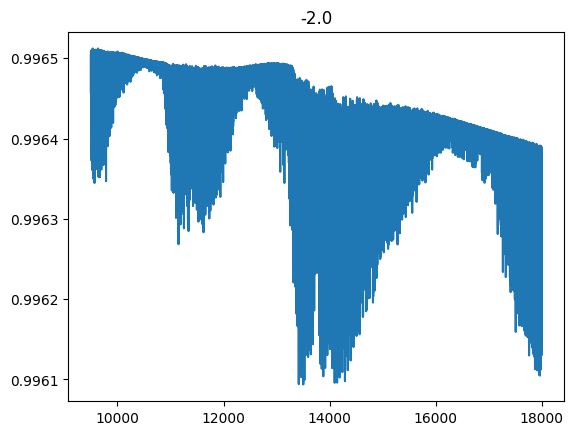

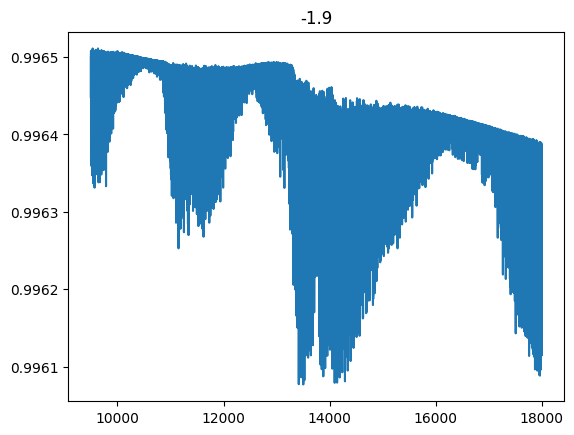

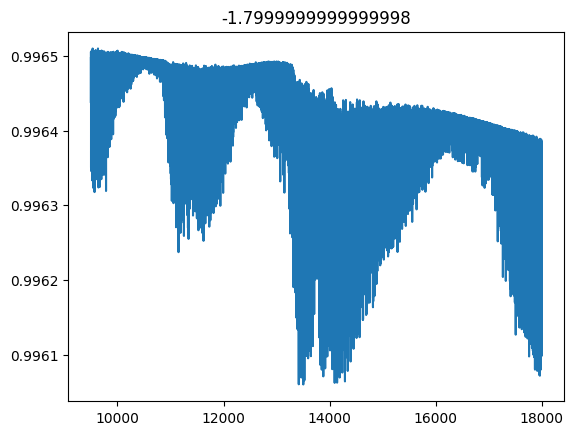

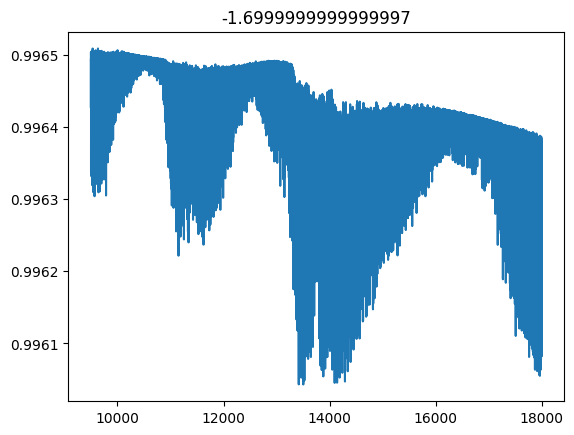

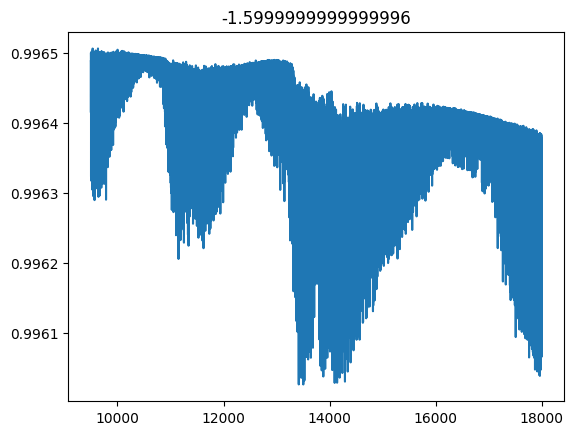

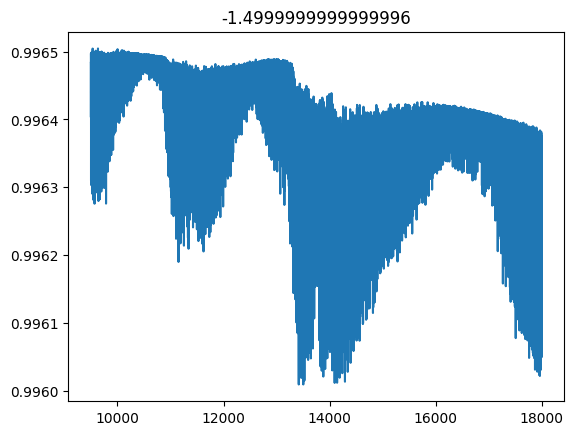

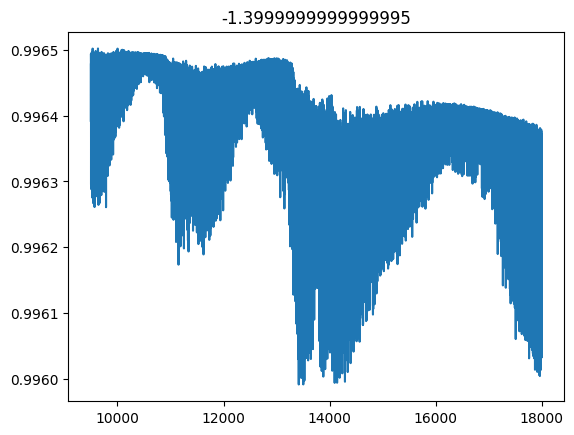

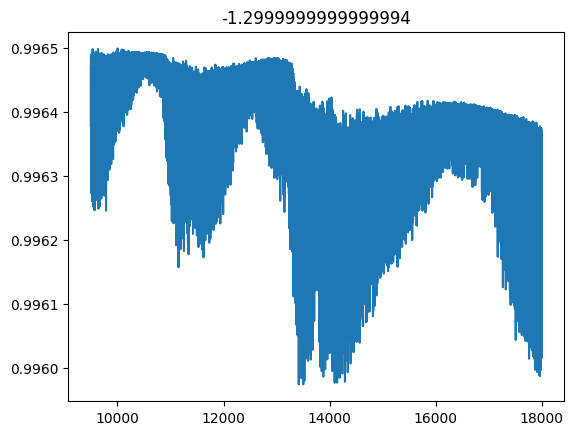

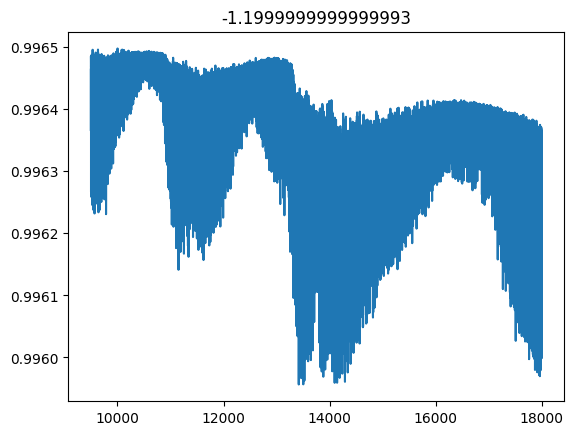

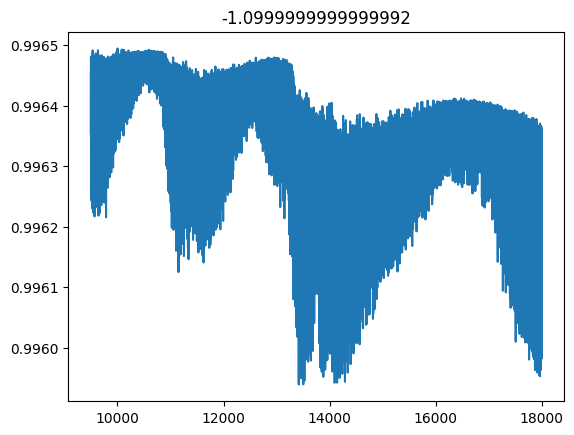

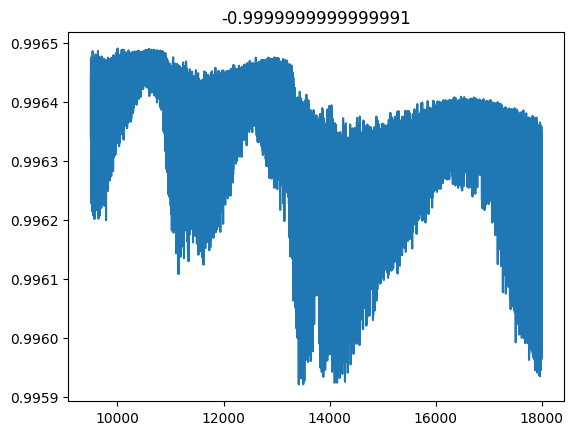

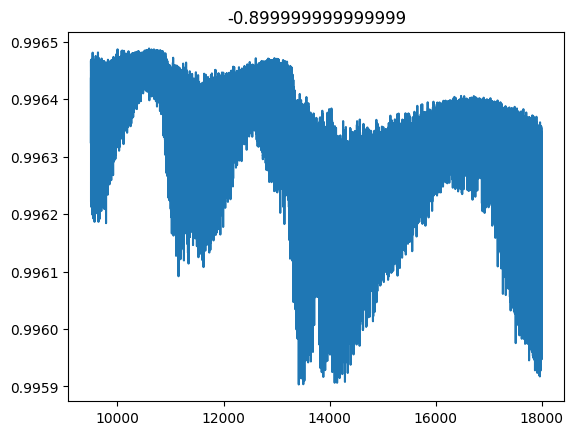

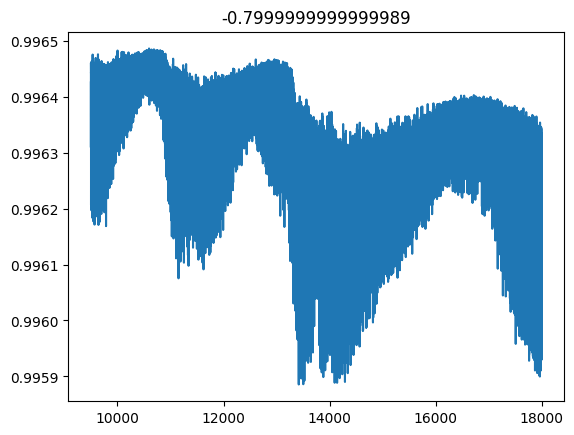

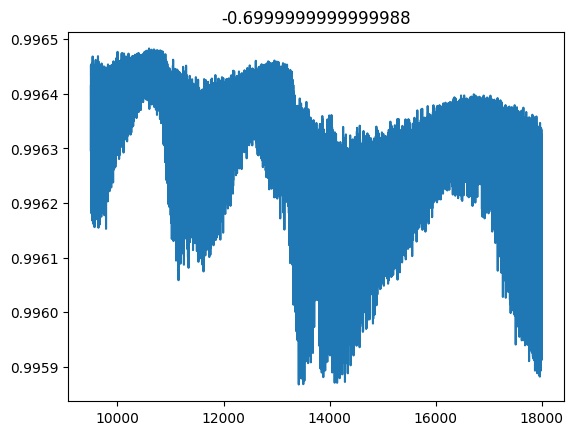

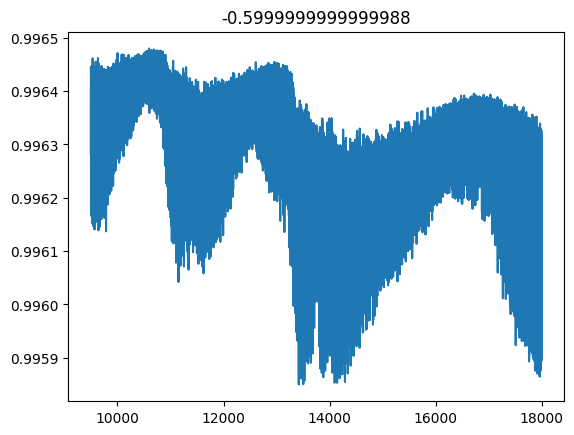

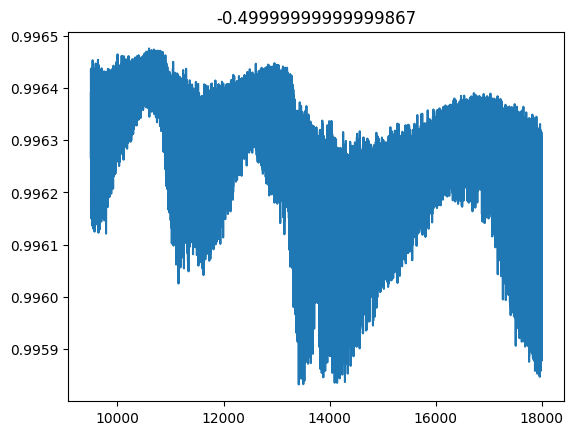

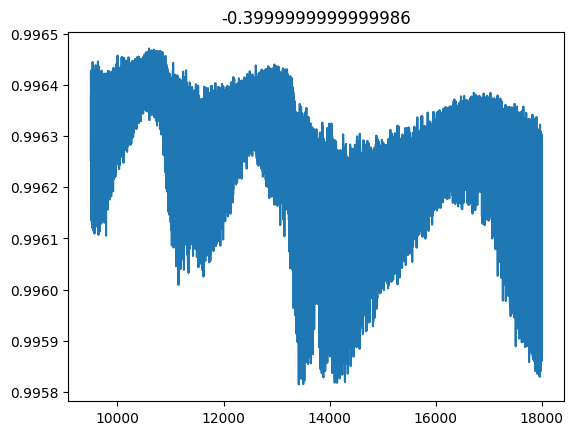

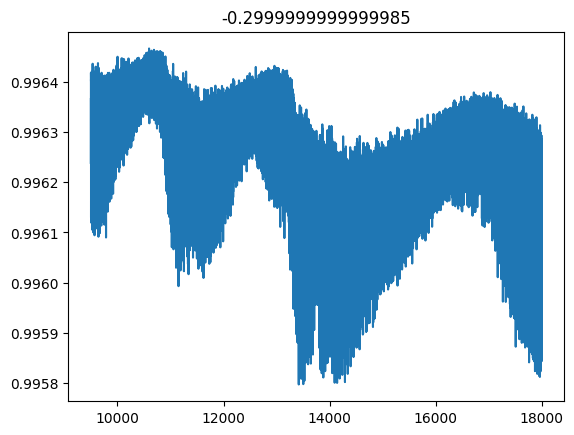

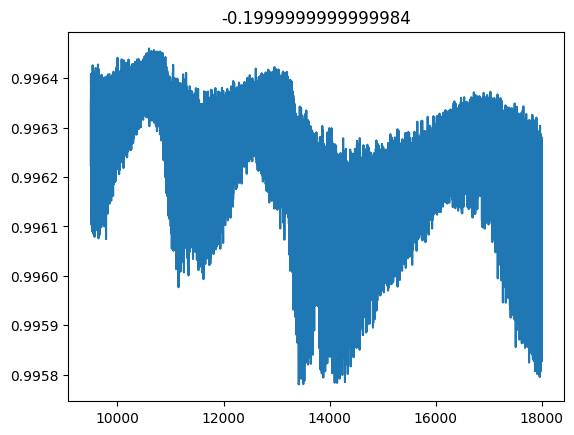

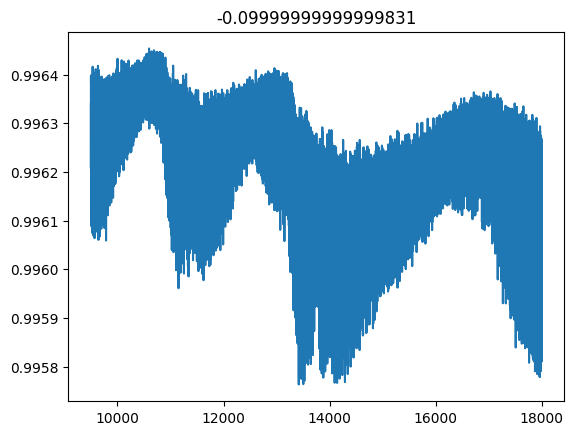

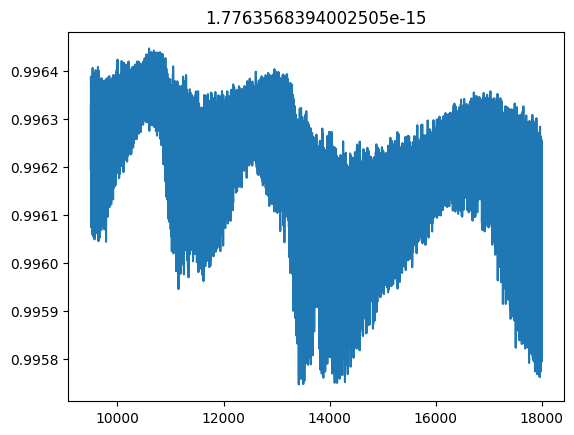

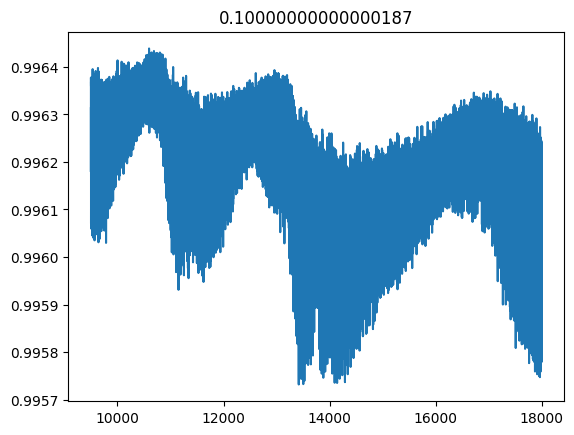

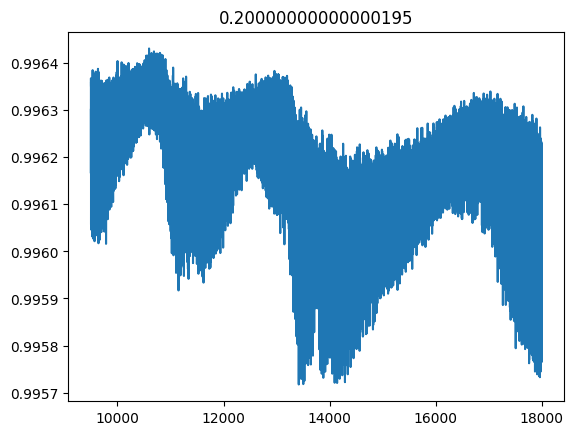

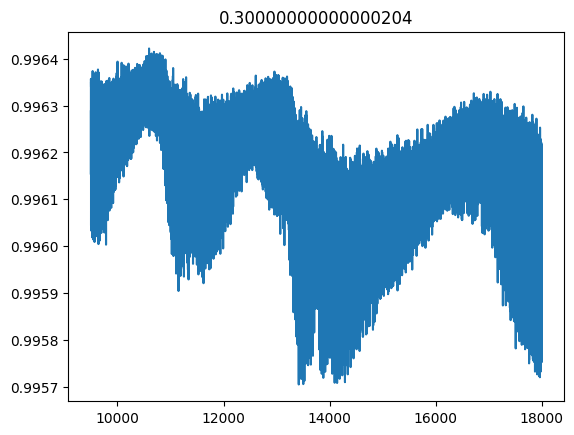

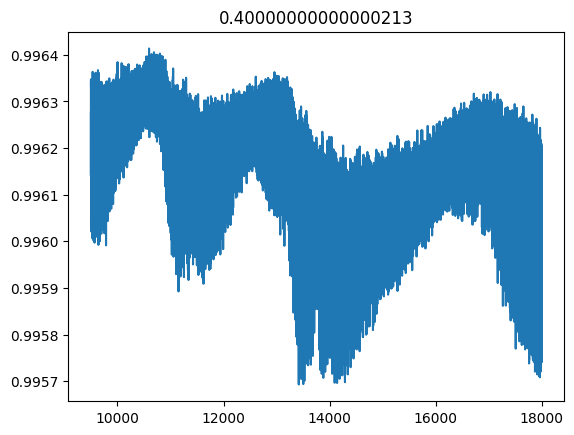

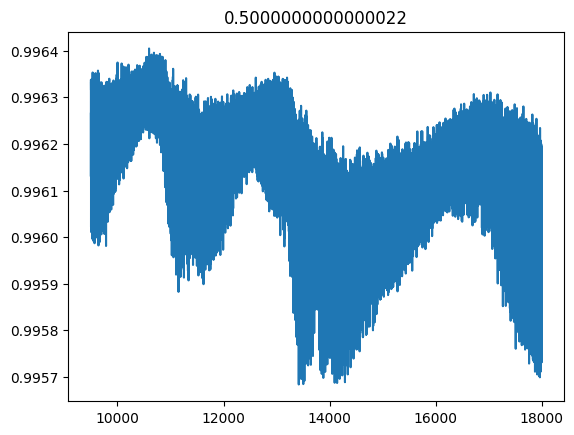

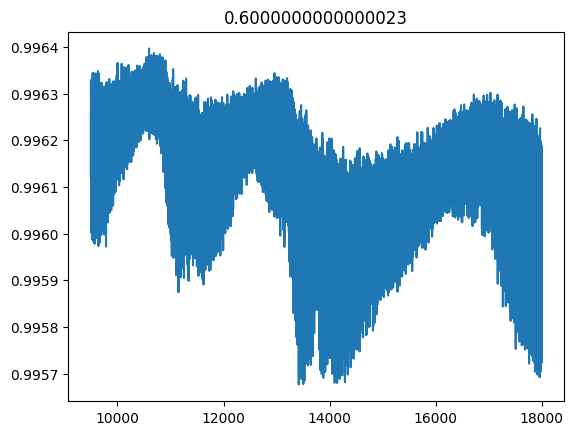

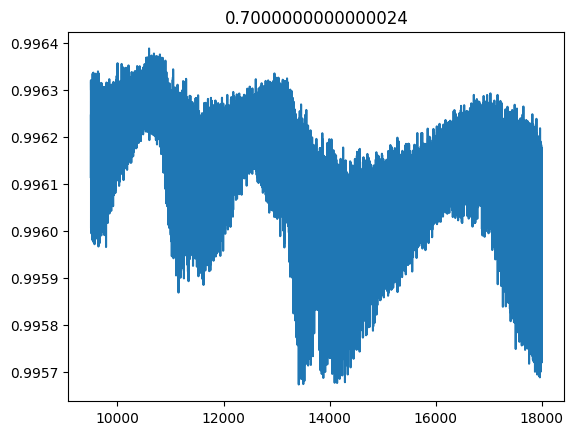

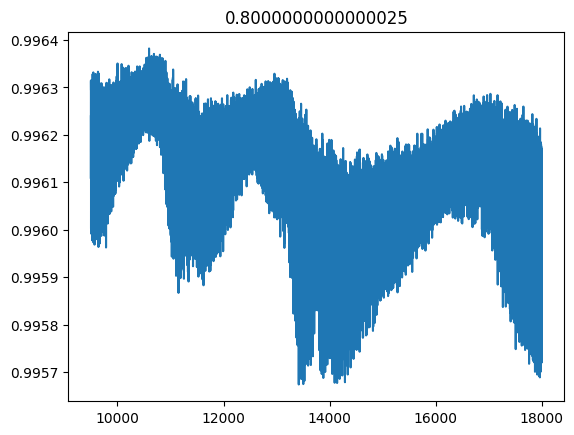

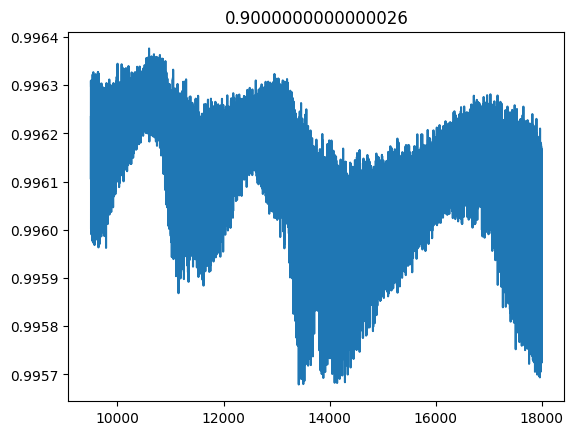

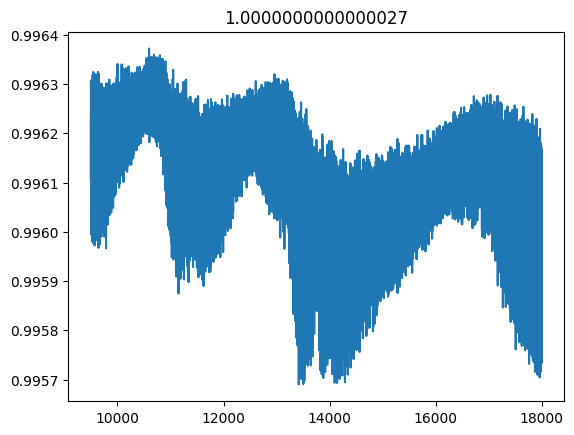

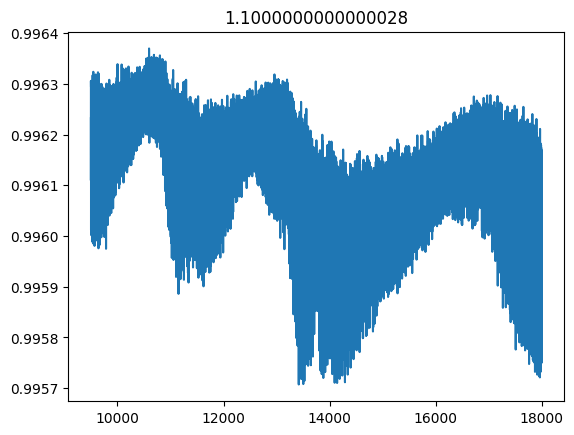

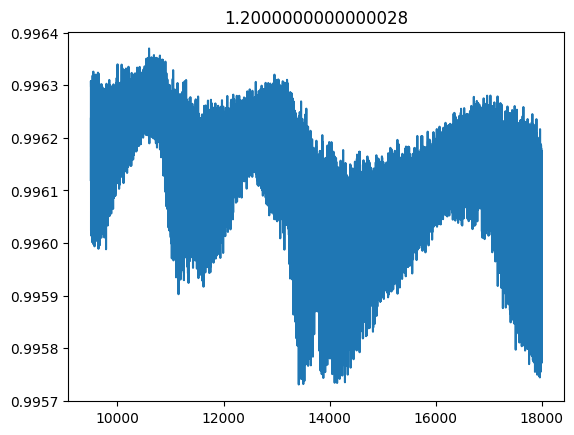

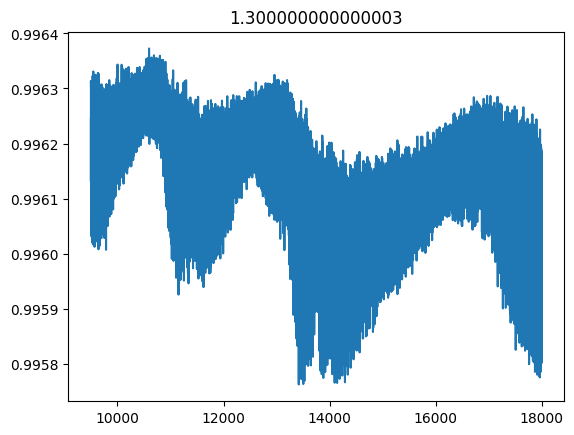

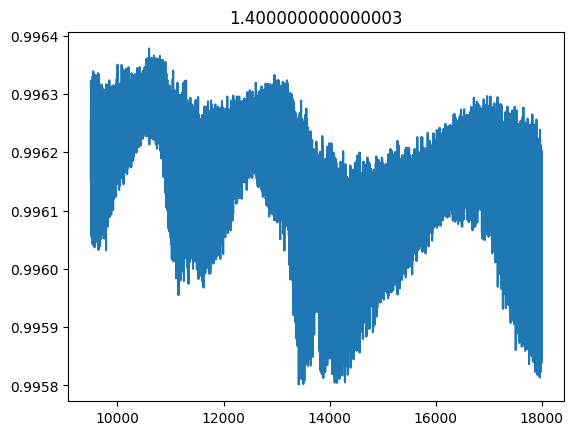

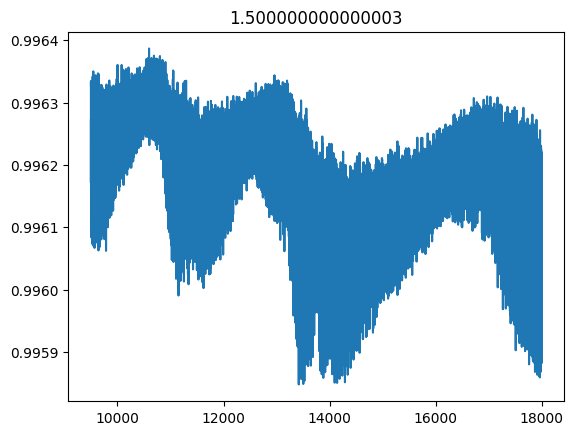

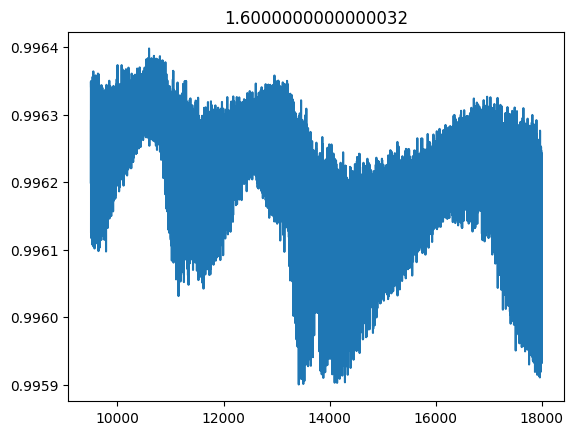

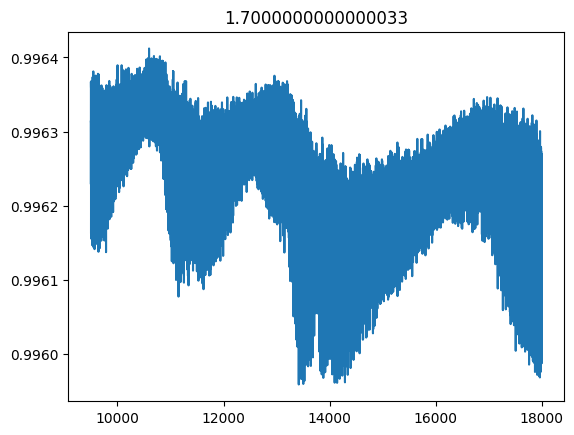

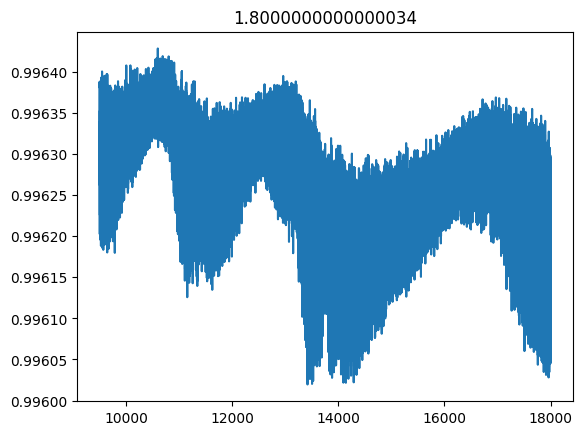

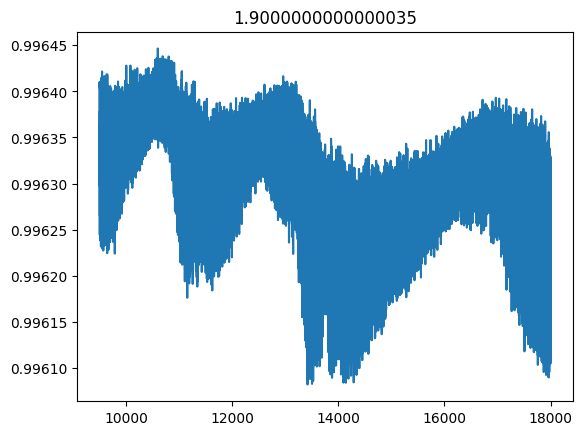

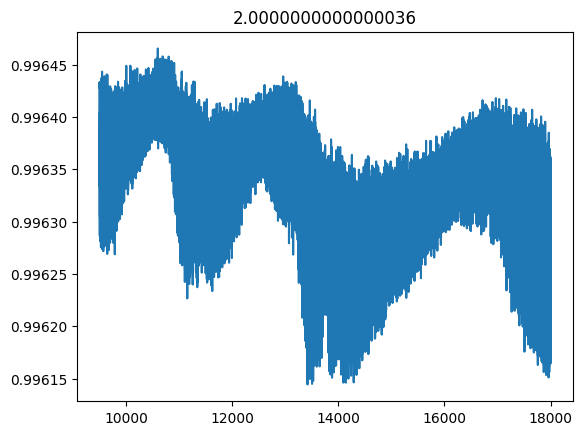

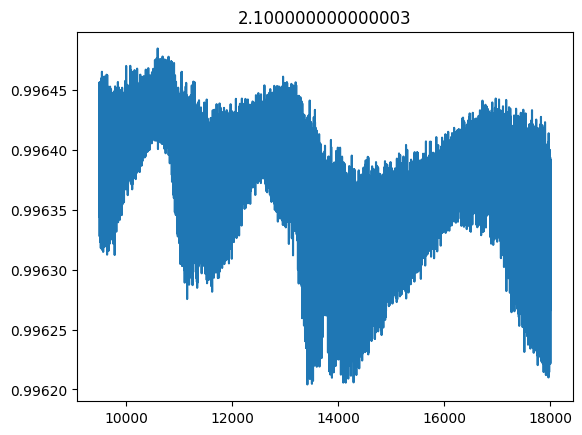

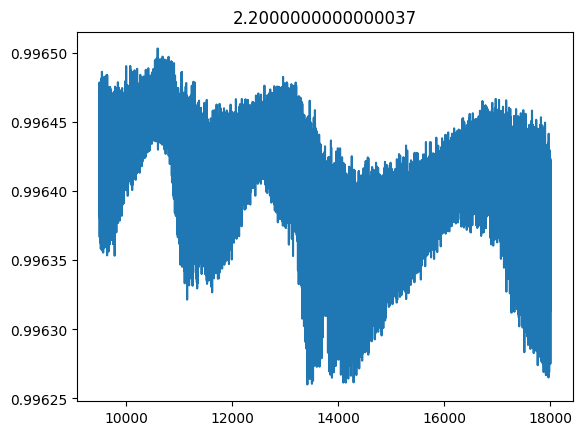

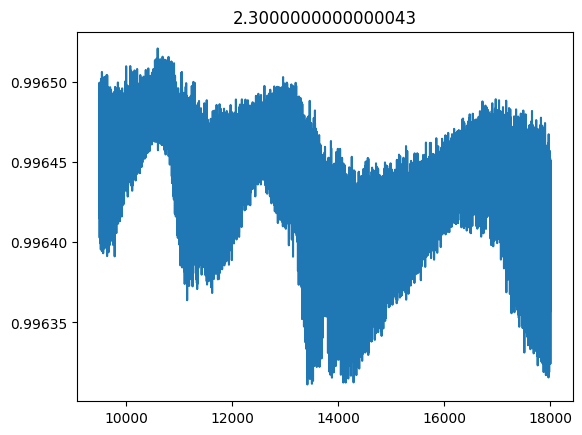

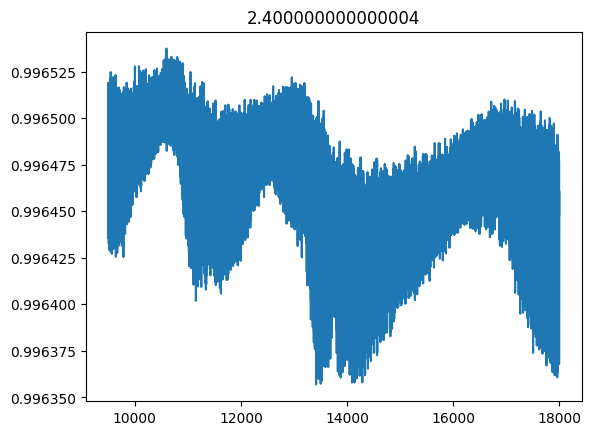

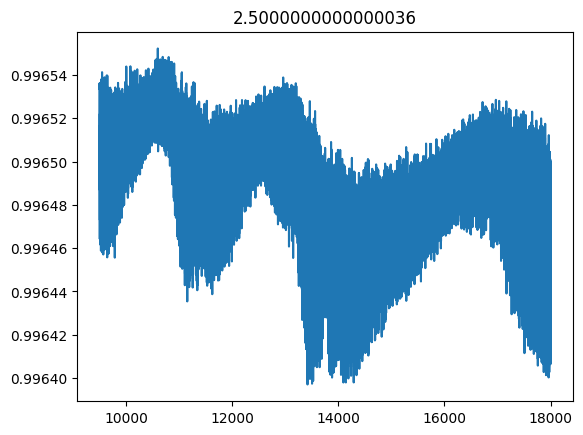

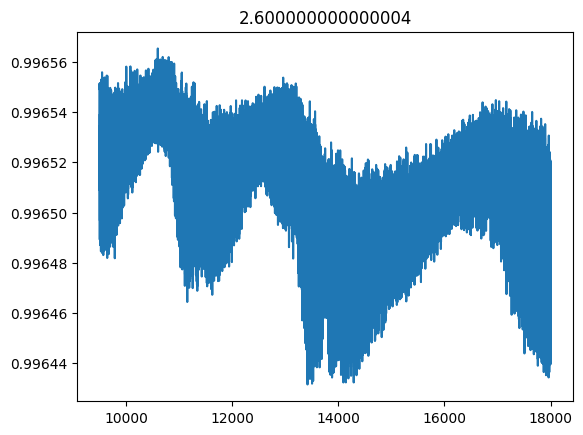

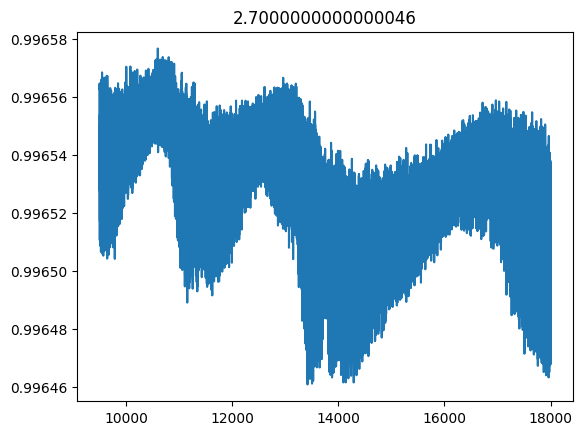

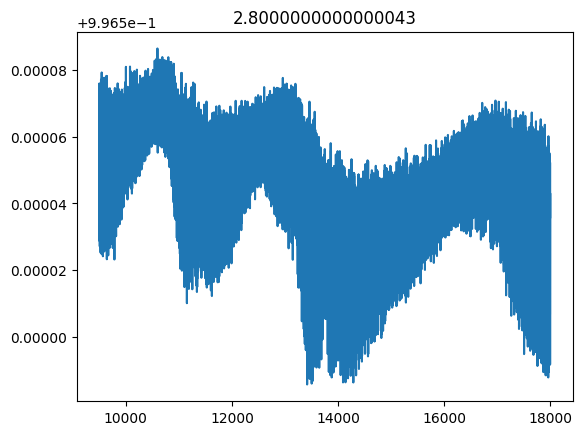

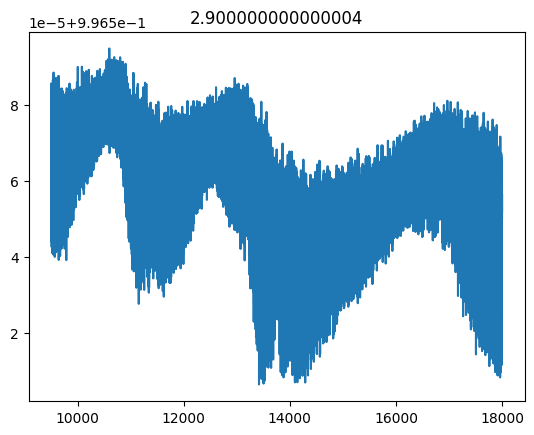

In [ ]:
for i in range(len(modflux_planet)):
    plt.figure()
    plt.plot(modwave_planet[i],modflux_planet[i])
    plt.title(str(metallicity[i]))
    plt.show()
    plt.close()

# pRT 3 (use for_pRT_31014 kernel)

In [1]:
from petitRADTRANS.spectral_model import SpectralModel

import os

import matplotlib.pyplot as plt
import numpy as np

import petitRADTRANS.physical_constants as cst
from petitRADTRANS.planet import Planet

from tqdm.notebook import tnrange,tqdm
import multiprocess as mp
from functools import partial

from scipy.ndimage import gaussian_filter1d

from function import inst_gaussian
from function import rotation_flux
from function import high_pass_filter

import warnings
warnings.filterwarnings('ignore')

# planet = Planet.get('HD 189733 b')

In [2]:
def compute_spec(metal,temp):

    spectral_model = SpectralModel(

        # Radtrans parameters
        pressures = np.logspace(-8, 2, 100),
        line_species = [
            'H2O'
        ],
        rayleigh_species=['H2', 'He'],
        gas_continuum_contributors=['H2-H2', 'H2-He'],
        wavelength_boundaries=[0.95, 1.8],
        line_opacity_mode='lbl',

        # SpectralModel additional parameters

        # Planet parameters
        planet_radius = 0.811 * cst.r_jup_mean,
        reference_gravity = cst.G * 0.322 * cst.m_jup / (0.811 * cst.r_jup_mean) ** 2,
        reference_pressure = 10,
        star_radius = 1.41 * cst.r_sun,

        # Temperature profile parameters (isothermal by default)
        temperature = temp,

        # Mass fractions
        use_equilibrium_chemistry = True,
        metallicity = 10**metal,  # times solar

        # Observation parameters
        convolve_resolving_power = 80400,

        # # Mass fractions
        # imposed_mass_fractions={  # these can also be arrays of the same size as pressures
        #      'H2O': 1e-3
        # },
        filling_species={ # automatically fill the atmosphere with H2 and He, such that the sum of MMRs is equal to 1 and H2/He = 37/12
            'H2': 37,
            'He': 12
        }
    )

    wavelengths, transit_radii = spectral_model.calculate_spectrum(
        mode='transmission',
        update_parameters=True,
        scale=True,  # this will build notably the temperature and mass fractions profile
        convolve=True
    )
    
    return wavelengths[0], transit_radii[0]

In [6]:
metallicity = np.arange(-4.,4.,0.1)
t_eq = np.arange(2500,4100,100)

flux_model = {}
wave_model = {}
for temp in tqdm(t_eq):
    flux_model[temp] = {} 
    wave_model[temp] = {}
    if __name__ == '__main__':
        with mp.Pool(10) as pool:

            results = pool.map(partial(compute_spec, temp=temp), metallicity)
            t = np.asarray(results)

            wave_model[temp] = t[:,0]
            flux_model[temp] = t[:,1]
            # metal = t[:]

# model = {}
# for temp in tqdm(t_eq):
#     model[temp] = {} 
#     if __name__ == '__main__':
#         with mp.Pool(8) as pool:
#             model[temp] = pool.map(partial(compute_spec,temp=temp),metallicity)

  0%|          | 0/16 [00:00<?, ?it/s]

In [7]:
#saving model
import pickle
with open('models/HD149026b_H2OPOKAZ_FeHm4top4step0d1_COsolar_isoTeff2500to4000step100_cloudFalseP010_abundCE_flux_woRotBroad.pkl', 'wb') as f:
    pickle.dump(flux_model, f)
with open('models/HD149026b_H2OPOKAZ_FeHm4top4step0d1_COsolar_isoTeff2500to4000step100_cloudFalseP010_abundCE_wave_woRotBroad.pkl', 'wb') as f:
    pickle.dump(wave_model, f)

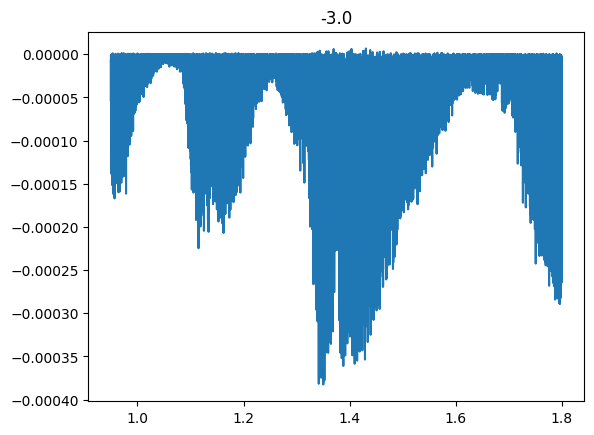

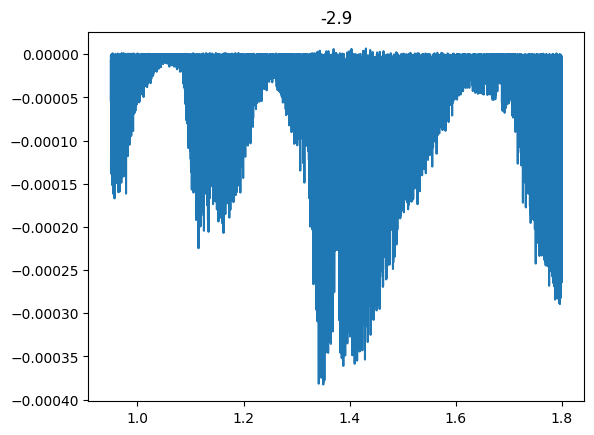

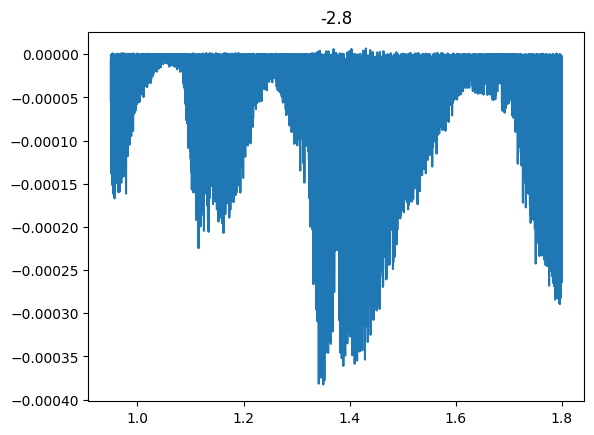

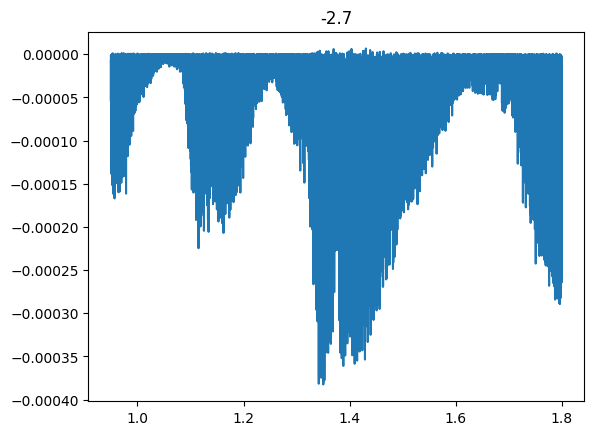

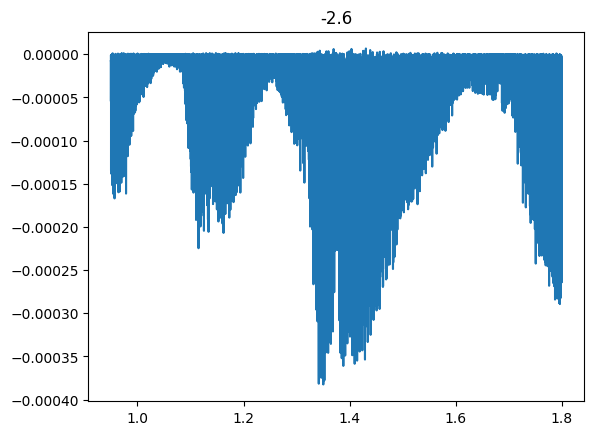

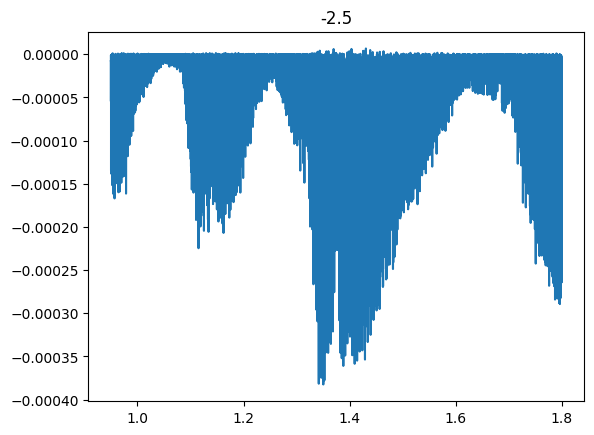

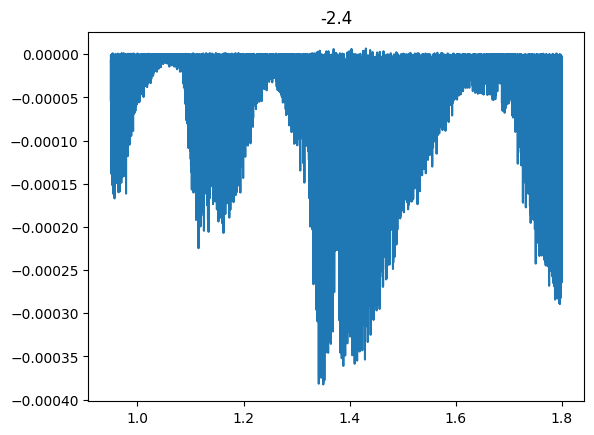

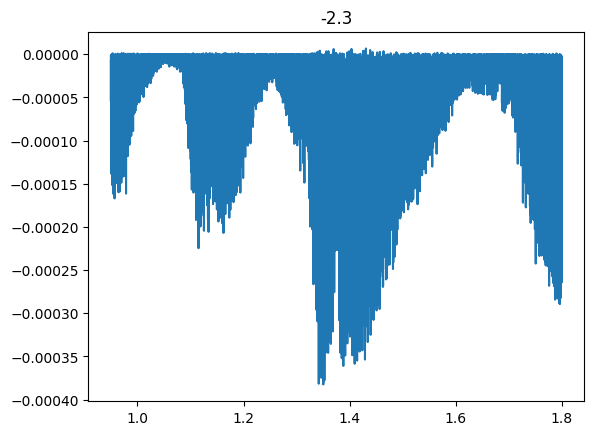

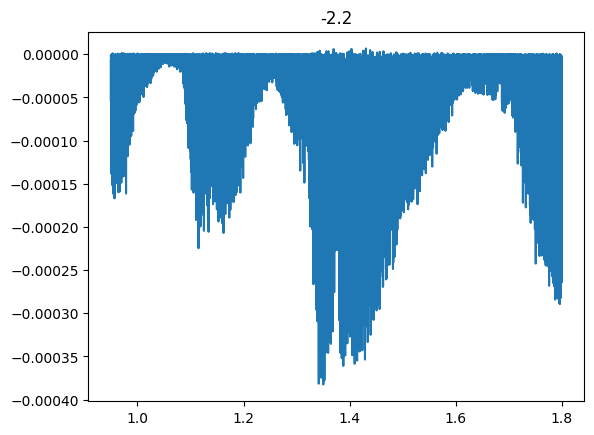

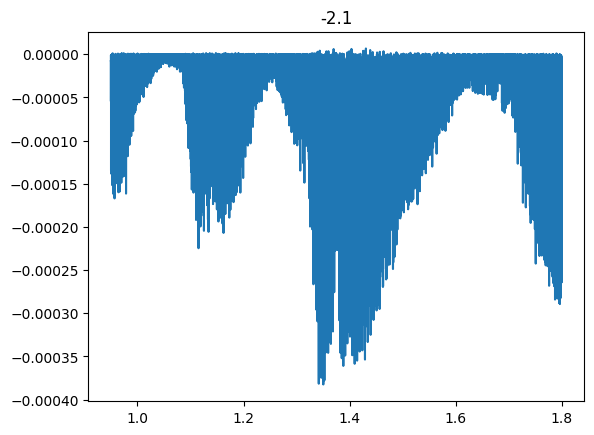

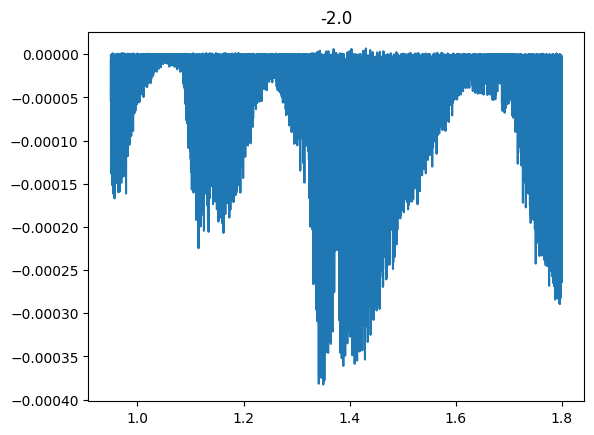

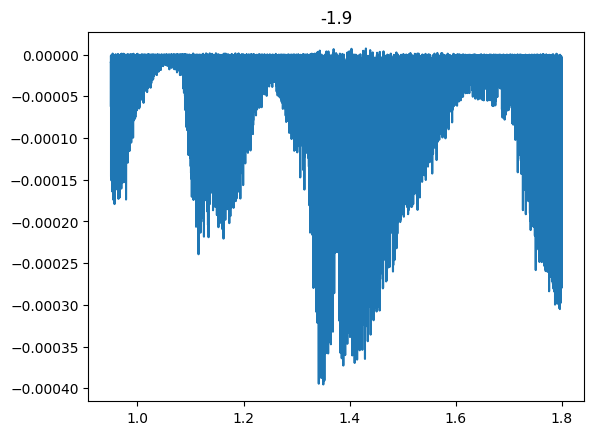

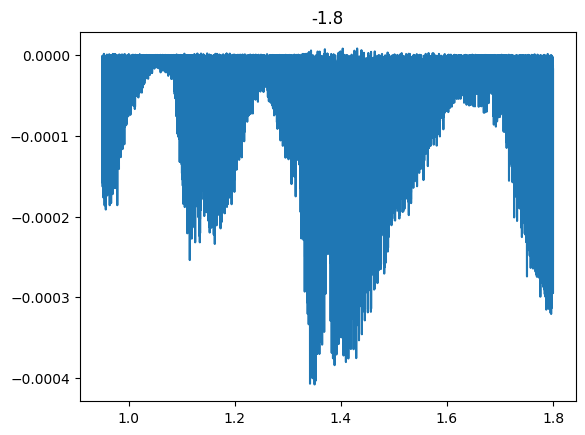

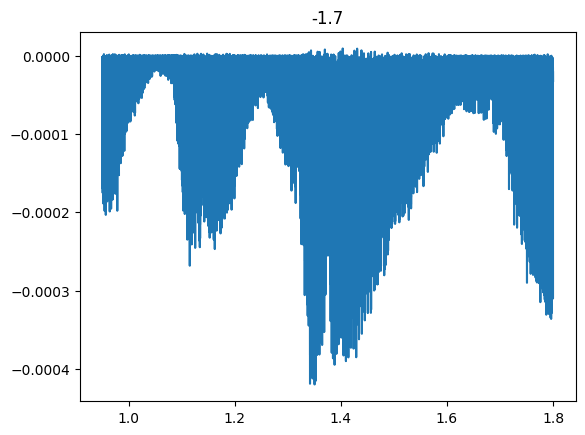

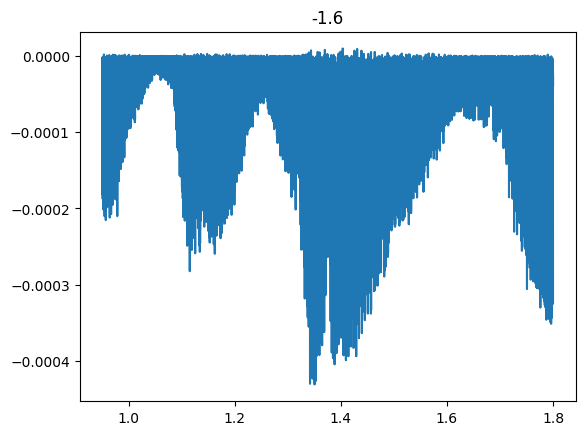

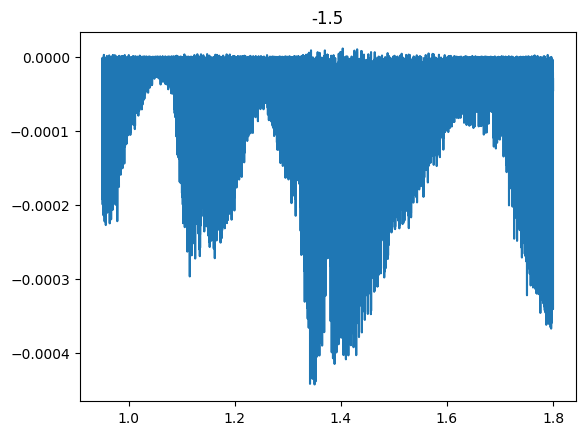

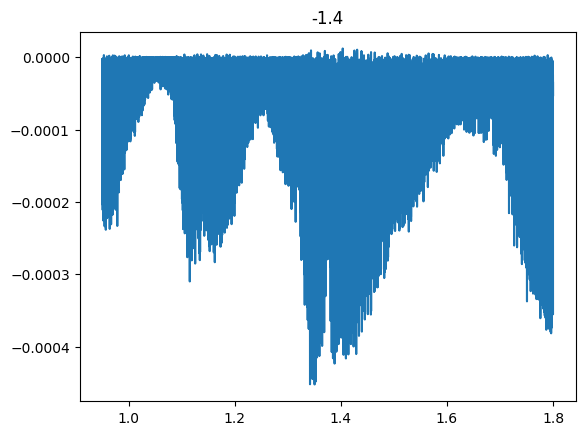

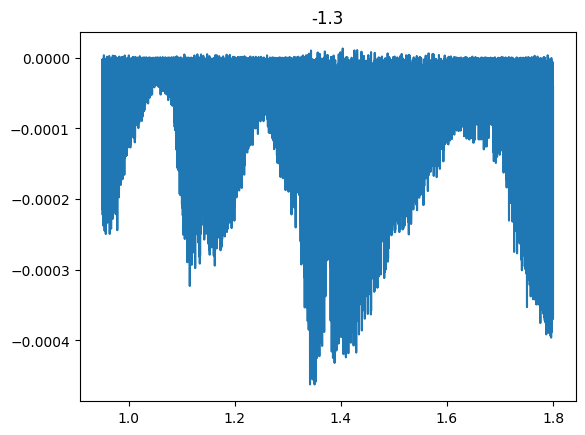

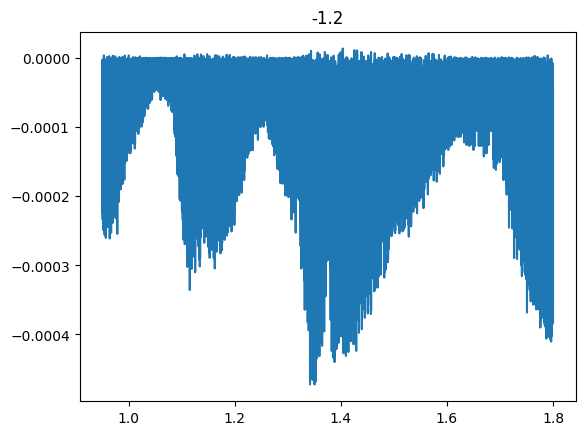

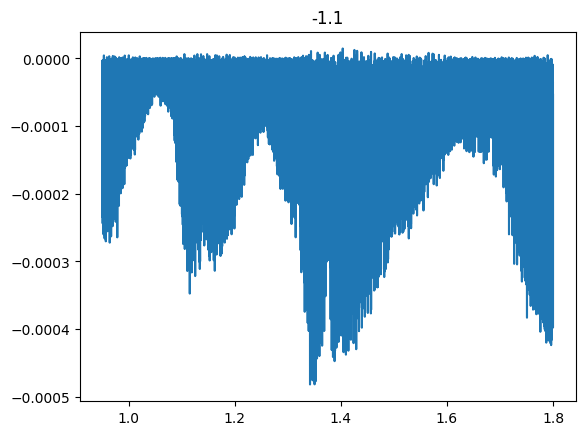

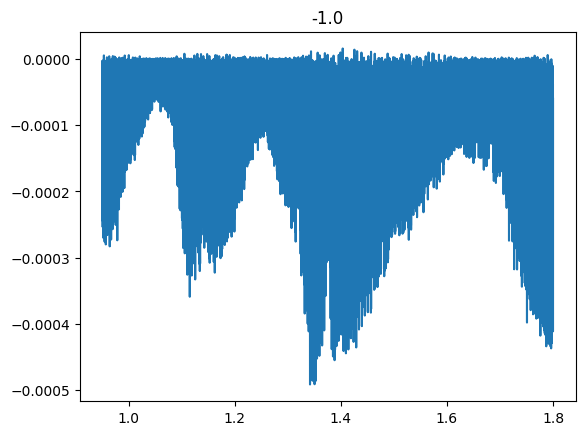

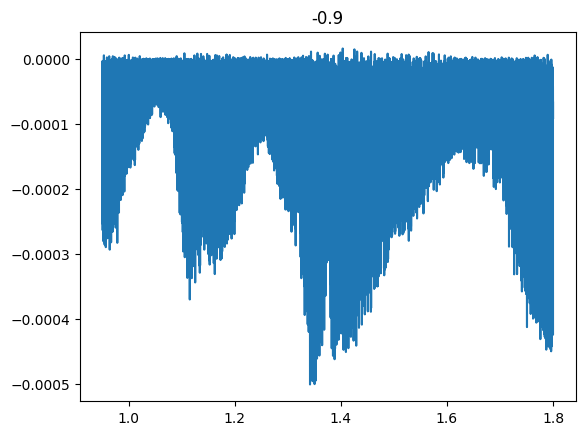

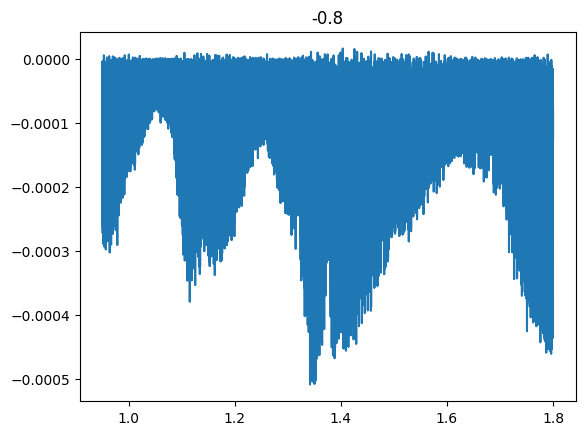

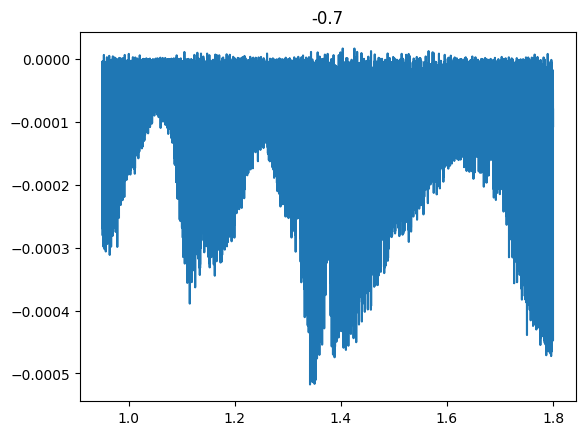

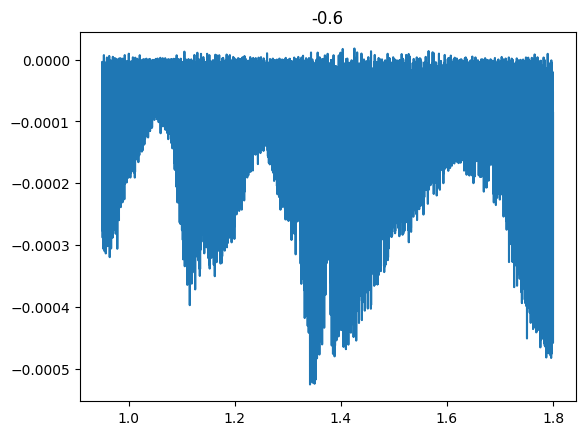

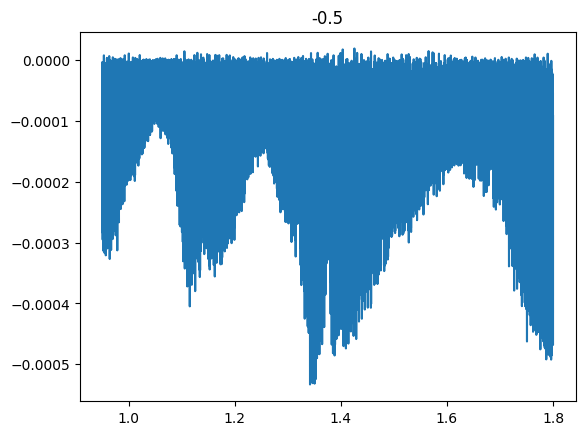

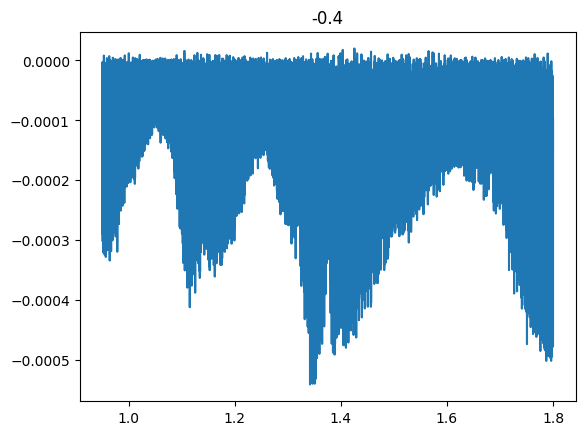

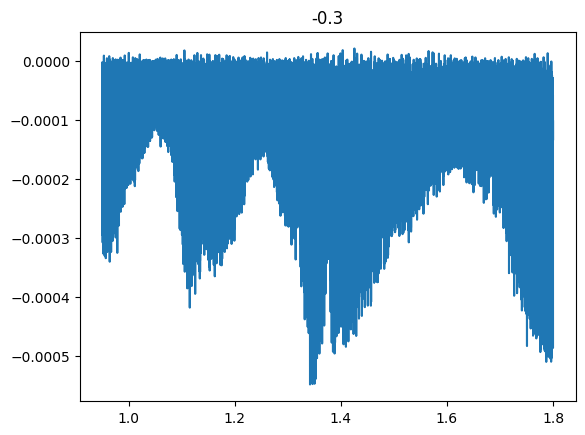

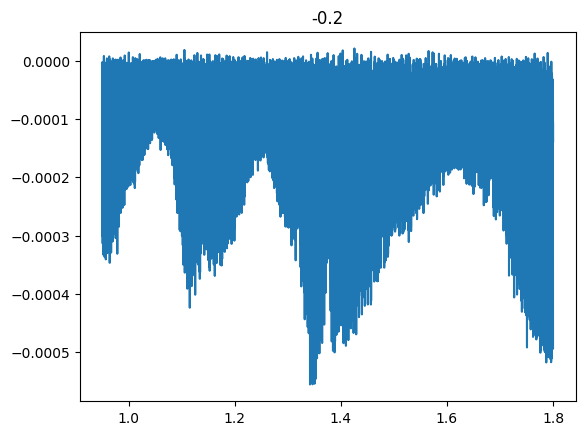

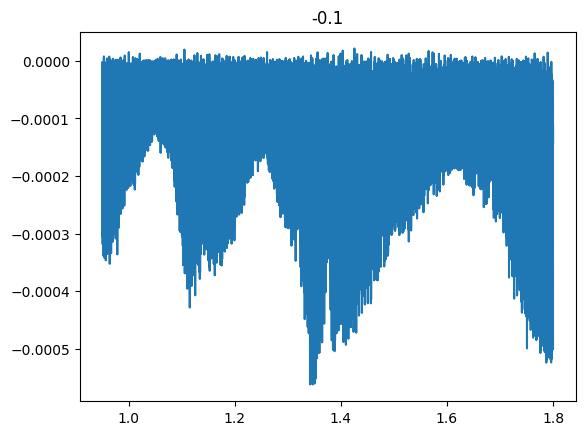

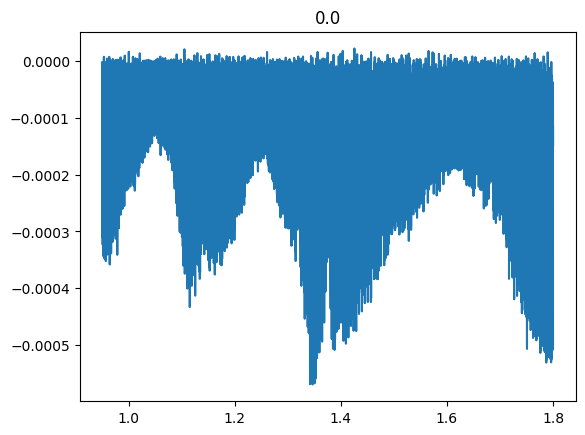

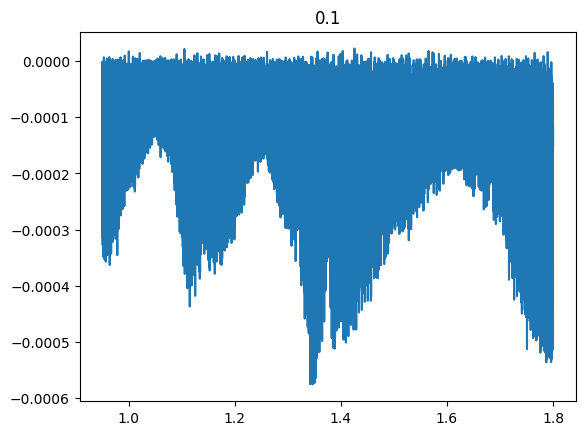

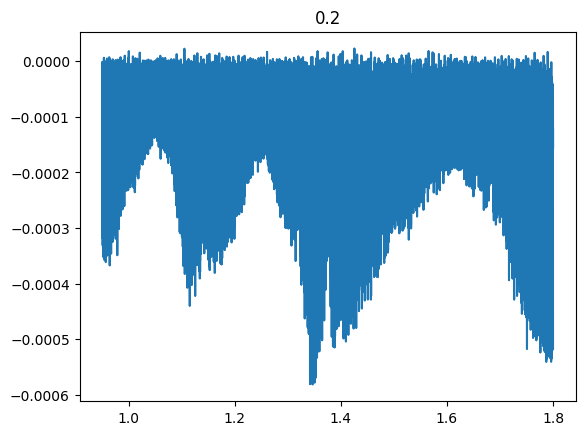

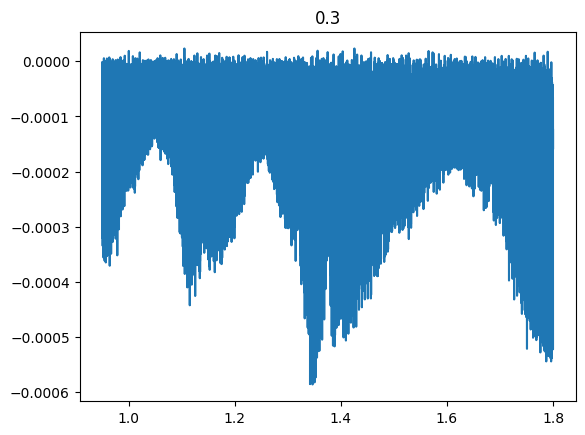

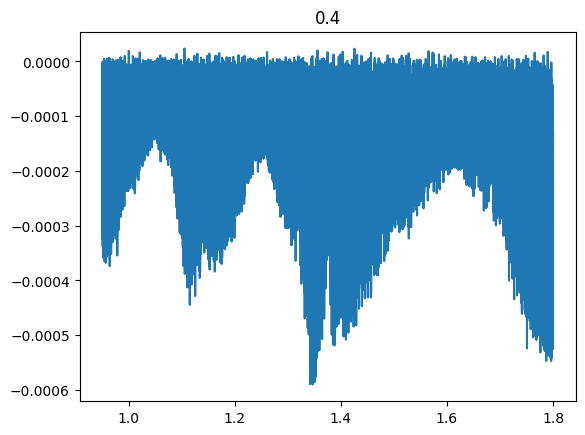

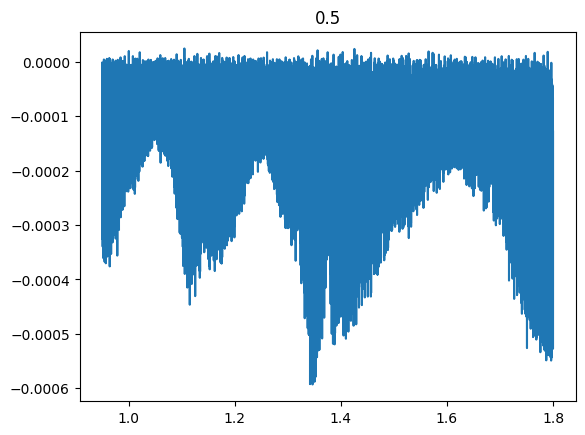

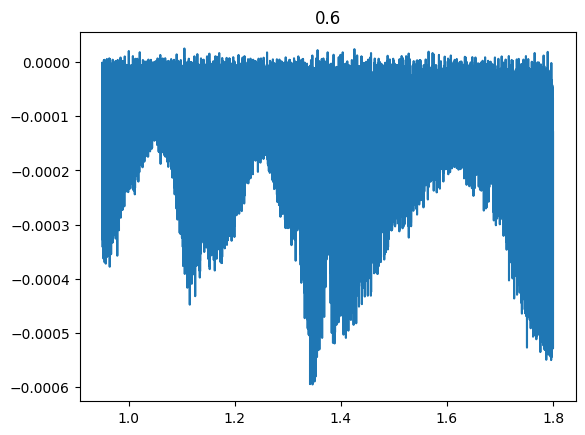

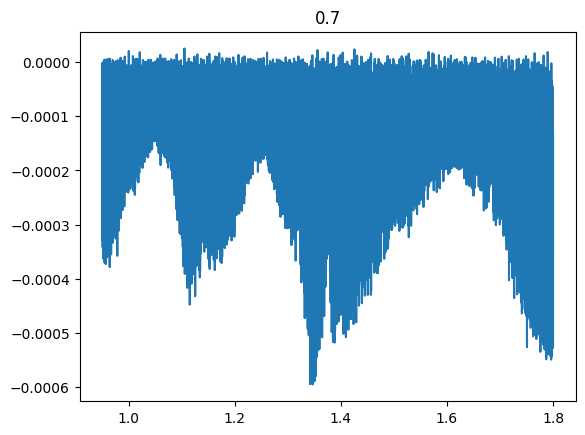

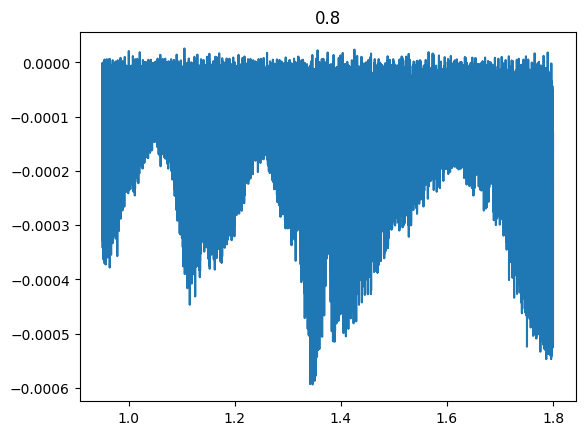

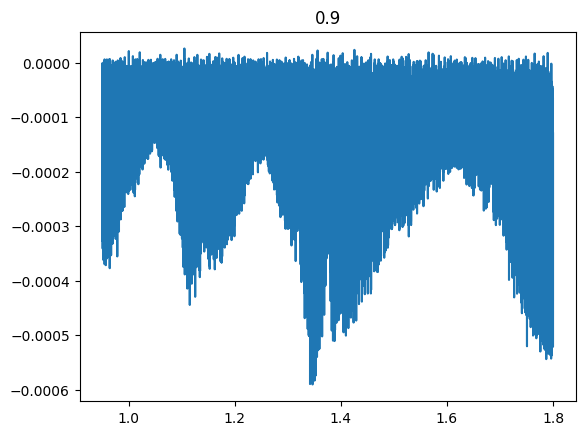

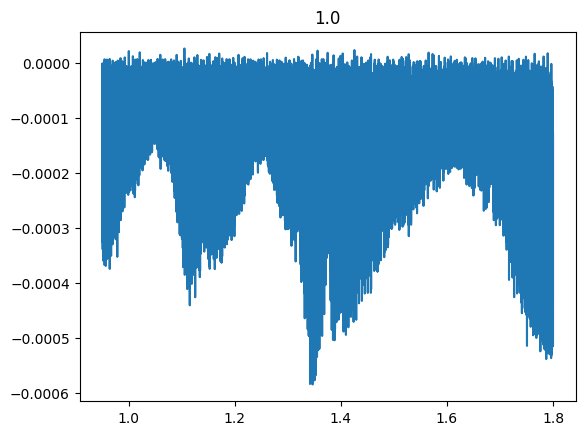

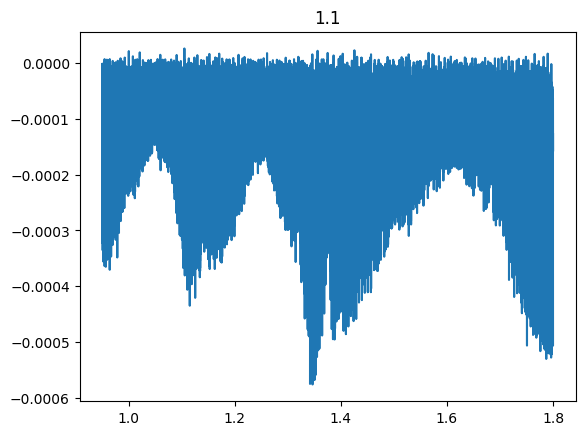

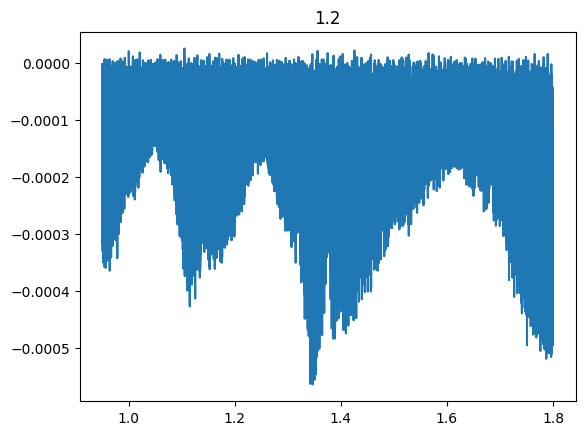

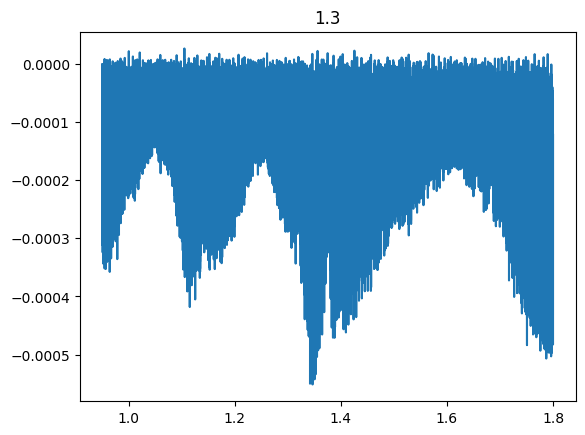

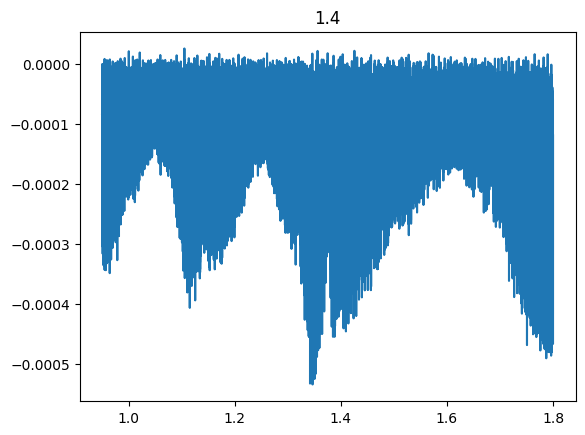

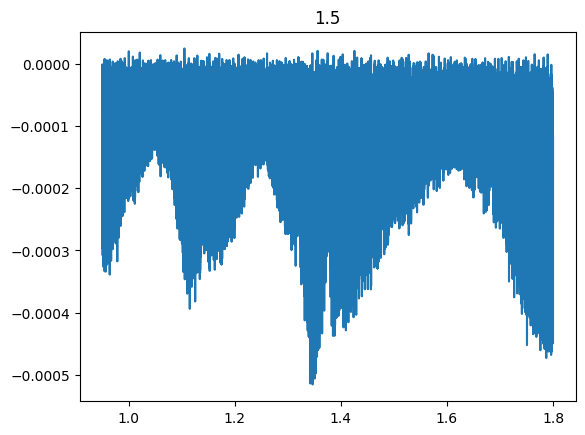

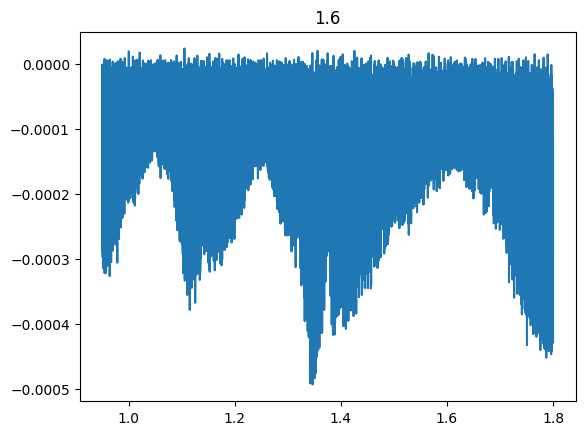

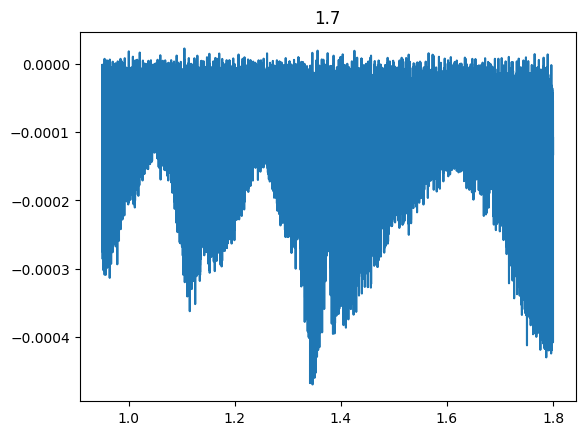

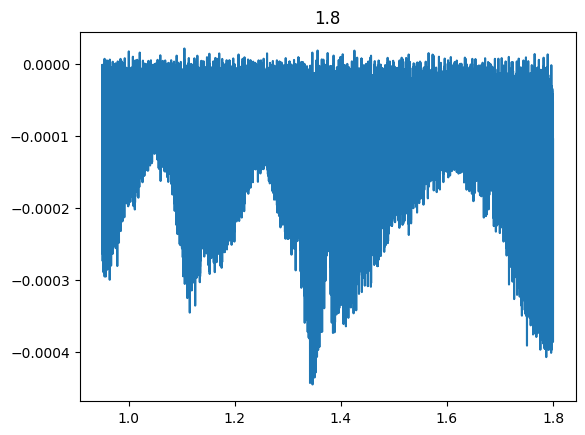

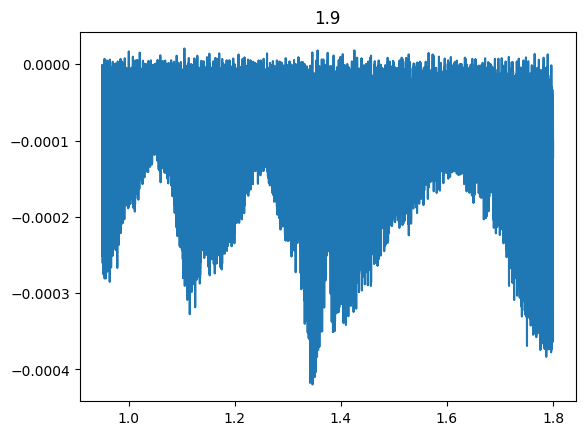

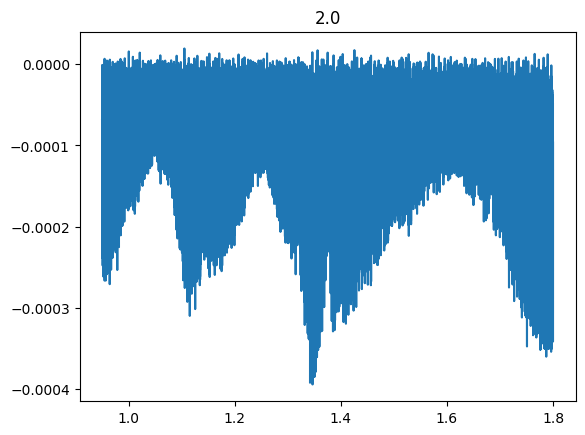

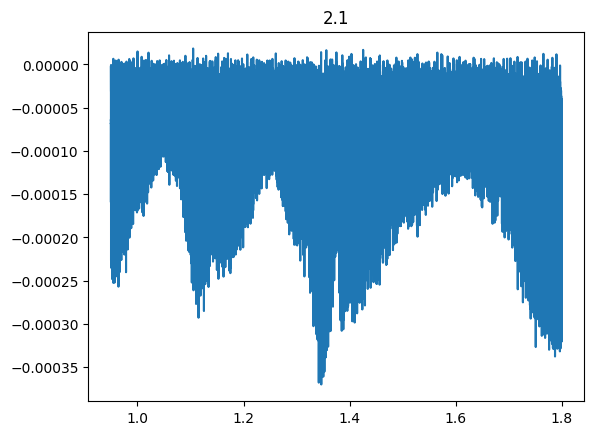

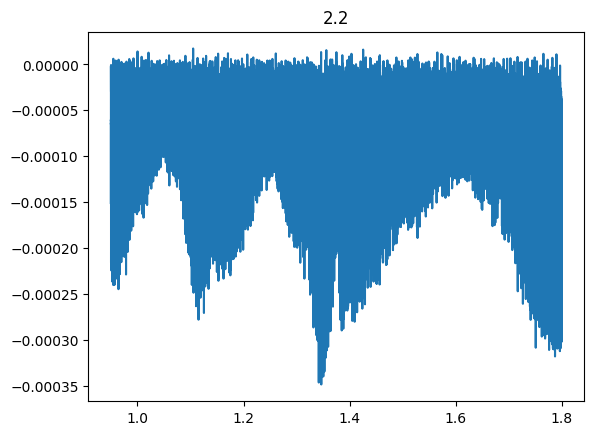

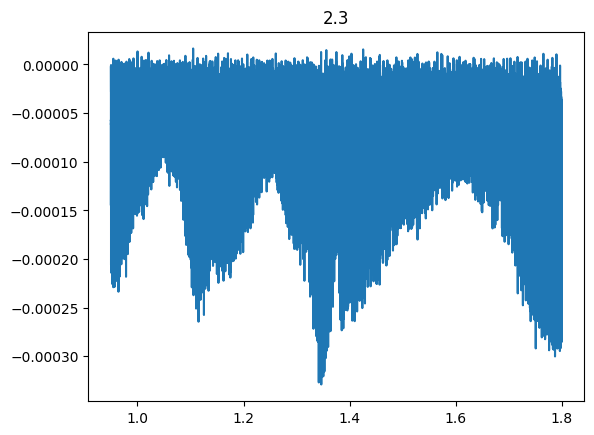

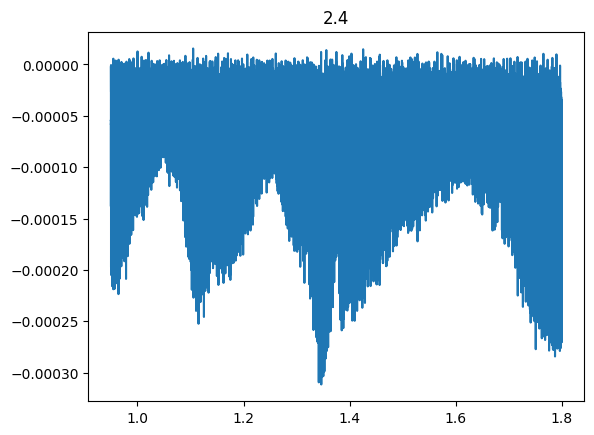

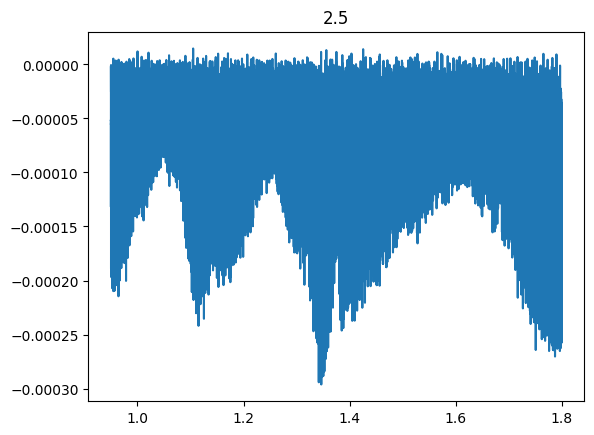

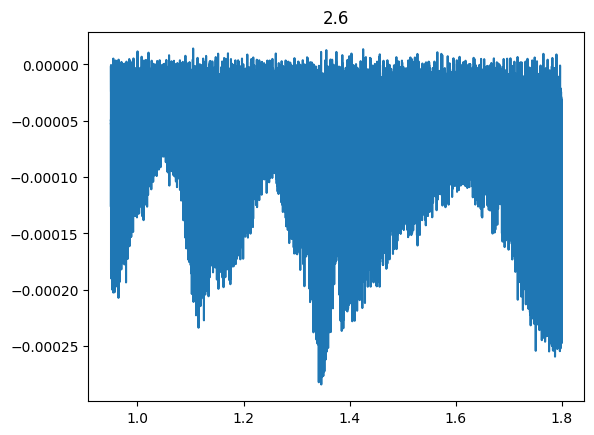

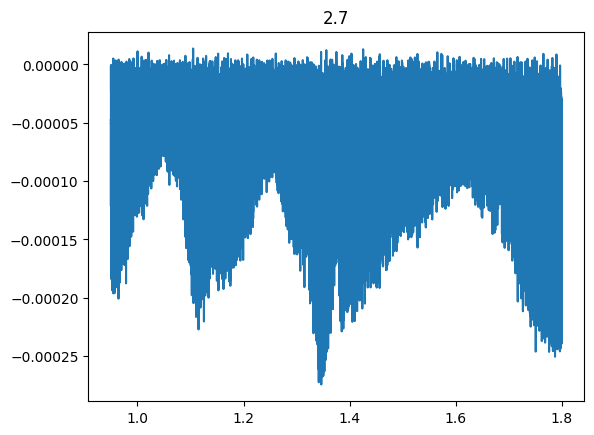

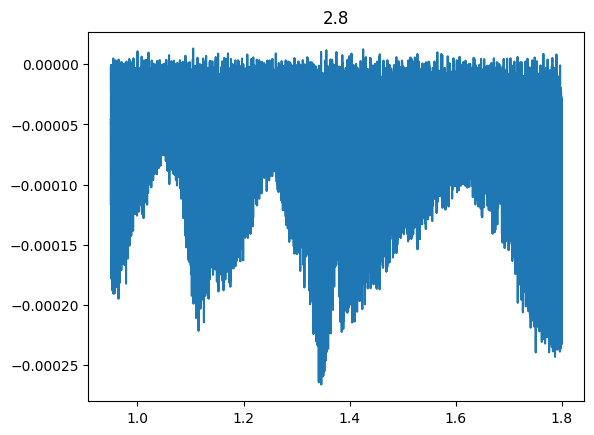

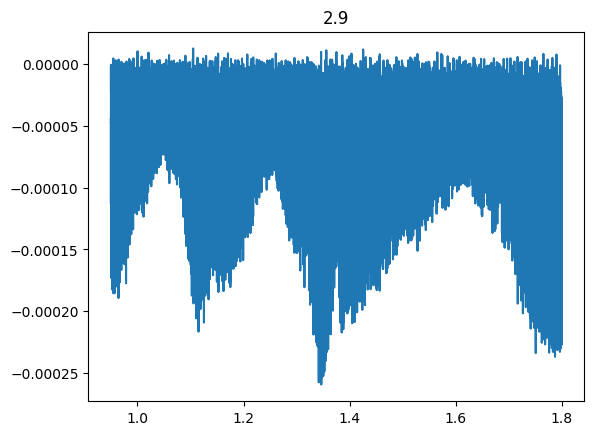

In [10]:
for idx in range(len(metallicity)):
    plt.figure()
    plt.plot(spec[idx][0]*1e8,spec[idx][1])
    plt.title(round(metallicity[idx],1))
    plt.show()